# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [7]:
# Import warnings
import warnings
warnings.filterwarnings("ignore")


In [8]:
# Import the libraries you will be using for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2

# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

In [10]:
# Try loading one file
df = pd.read_parquet('2023-1.parquet')
df.shape

(3041714, 19)

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [5]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [ ]:
import os
os.chdir

# Create a list of all the twelve files to read
file_list = os.listdir()
file_list

In [100]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# initialise an empty dataframe
df = pd.DataFrame()

# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(), file_name)

        # Reading the current file
        monthly_data_df = pd.read_parquet(file_path)

        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data_df = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        for date in monthly_data_df['tpep_pickup_datetime'].dt.date.unique():
            daily_data_df = monthly_data_df[monthly_data_df['tpep_pickup_datetime'].dt.date == date]

            # Iterate through each hour of the selected date
            for hour in range(24):
                hourly_data_df = daily_data_df[daily_data_df['tpep_pickup_datetime'].dt.hour == hour]

                # Sample 5% of the hourly data randomly
                sample_frac_df = hourly_data_df.sample(frac=0.01, random_state=42) 
                                
                # add data of this hour to the dataframe
                sampled_data_df = pd.concat([sampled_data_df, sample_frac_df])

        # Concatenate the sampled data of all the dates to a single dataframe
        df = pd.concat([df, sampled_data_df])

    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

Error reading file yearly_sampled_data.parquet: 'tpep_pickup_datetime'


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [45]:
# Store the df in csv/parquet
df.to_parquet('combined_df.parquet', index=False)

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [11]:
# Load the new data file
combined_df = pd.read_parquet('combined_df.parquet')

In [12]:
combined_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,Airport_fee
0,2,2023-01-01 00:07:18,2023-01-01 00:23:15,1.0,7.74,1.0,N,138,256,2,32.40,6.0,0.5,0.00,0.0,1.0,41.15,0.0,1.25,NaN
1,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,N,161,237,1,7.90,1.0,0.5,2.58,0.0,1.0,15.48,2.5,0.00,NaN
2,2,2023-01-01 00:14:03,2023-01-01 00:24:36,3.0,1.44,1.0,N,237,141,2,11.40,1.0,0.5,0.00,0.0,1.0,16.40,2.5,0.00,NaN
3,2,2023-01-01 00:24:30,2023-01-01 00:29:55,1.0,0.54,1.0,N,143,142,2,6.50,1.0,0.5,0.00,0.0,1.0,11.50,2.5,0.00,NaN
4,2,2023-01-01 00:43:00,2023-01-01 01:01:00,NaN,19.24,NaN,None,66,107,0,25.64,0.0,0.5,5.93,0.0,1.0,35.57,NaN,NaN,NaN


In [13]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379268 entries, 0 to 379267
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               379268 non-null  int64         
 1   tpep_pickup_datetime   379268 non-null  datetime64[us]
 2   tpep_dropoff_datetime  379268 non-null  datetime64[us]
 3   passenger_count        366326 non-null  float64       
 4   trip_distance          379268 non-null  float64       
 5   RatecodeID             366326 non-null  float64       
 6   store_and_fwd_flag     366326 non-null  object        
 7   PULocationID           379268 non-null  int64         
 8   DOLocationID           379268 non-null  int64         
 9   payment_type           379268 non-null  int64         
 10  fare_amount            379268 non-null  float64       
 11  extra                  379268 non-null  float64       
 12  mta_tax                379268 non-null  floa

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [14]:
# Fix the index and drop any columns that are not needed
combined_df.reset_index(drop=True, inplace=True)

combined_df['store_and_fwd_flag'].value_counts()
combined_df.drop(columns=['store_and_fwd_flag'], inplace=True) 

100*combined_df.isnull().mean()

VendorID                  0.000000
tpep_pickup_datetime      0.000000
tpep_dropoff_datetime     0.000000
passenger_count           3.412363
trip_distance             0.000000
RatecodeID                3.412363
PULocationID              0.000000
DOLocationID              0.000000
payment_type              0.000000
fare_amount               0.000000
extra                     0.000000
mta_tax                   0.000000
tip_amount                0.000000
tolls_amount              0.000000
improvement_surcharge     0.000000
total_amount              0.000000
congestion_surcharge      3.412363
airport_fee              92.176245
Airport_fee              11.236118
dtype: float64

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [15]:
# Combine the two airport fee columns
med = combined_df["Airport_fee"].median()
combined_df["Airport_fee"]=combined_df["Airport_fee"].fillna(med)

med = combined_df["airport_fee"].median()
combined_df["airport_fee"]=combined_df["airport_fee"].fillna(med)
    
combined_df['airport_fee'] = combined_df['airport_fee'] + combined_df['Airport_fee']
combined_df.drop("Airport_fee",axis=1,inplace=True)
combined_df.head(15)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:07:18,2023-01-01 00:23:15,1.0,7.74,1.0,138,256,2,32.40,6.0,0.5,0.00,0.0,1.0,41.15,0.0,1.25
1,2,2023-01-01 00:16:41,2023-01-01 00:21:46,2.0,1.24,1.0,161,237,1,7.90,1.0,0.5,2.58,0.0,1.0,15.48,2.5,0.00
2,2,2023-01-01 00:14:03,2023-01-01 00:24:36,3.0,1.44,1.0,237,141,2,11.40,1.0,0.5,0.00,0.0,1.0,16.40,2.5,0.00
3,2,2023-01-01 00:24:30,2023-01-01 00:29:55,1.0,0.54,1.0,143,142,2,6.50,1.0,0.5,0.00,0.0,1.0,11.50,2.5,0.00
4,2,2023-01-01 00:43:00,2023-01-01 01:01:00,NaN,19.24,NaN,66,107,0,25.64,0.0,0.5,5.93,0.0,1.0,35.57,NaN,0.00
5,1,2023-01-01 00:42:56,2023-01-01 01:16:33,2.0,7.10,1.0,246,37,1,34.50,3.5,0.5,7.90,0.0,1.0,47.40,2.5,0.00
6,2,2023-01-01 00:58:00,2023-01-01 01:08:31,2.0,1.59,1.0,79,164,1,11.40,1.0,0.5,3.28,0.0,1.0,19.68,2.5,0.00
7,2,2023-01-01 00:16:06,2023-01-01 00:31:59,1.0,3.16,1.0,79,256,1,19.10,1.0,0.5,6.02,0.0,1.0,30.12,2.5,0.00
8,2,2023-01-01 00:44:09,2023-01-01 01:01:17,1.0,7.64,1.0,132,95,1,31.70,1.0,0.5,7.09,0.0,1.0,42.54,0.0,1.25
9,1,2023-01-01 00:15:25,2023-01-01 00:22:35,2.0,0.90,1.0,148,114,1,7.90,3.5,0.5,1.00,0.0,1.0,13.90,2.5,0.00


**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [16]:
# check where values of fare amount are negative
combined_df[combined_df['fare_amount'] < 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee


Did you notice something different in the `RatecodeID` column for above records?

In [17]:
# Analyse RatecodeID for the negative fare amounts
combined_df['RatecodeID'].isna().sum()
combined_df['RatecodeID'].value_counts()


RatecodeID
1.0     345900
2.0      14327
99.0      2133
5.0       2066
3.0       1176
4.0        724
Name: count, dtype: int64

In [18]:
# Find which columns have negative values
nums = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
cleaned_df = combined_df.select_dtypes(include=nums) 
cleaned_df.apply(lambda x: x < 0).sum() 


VendorID                  0
passenger_count           0
trip_distance             0
RatecodeID                0
PULocationID              0
DOLocationID              0
payment_type              0
fare_amount               0
extra                     1
mta_tax                  15
tip_amount                0
tolls_amount              0
improvement_surcharge    15
total_amount             15
congestion_surcharge     10
airport_fee               3
dtype: int64

In [19]:
# fix these negative values
combined_df.drop(combined_df[combined_df['extra'] < 0].index, inplace = True)
combined_df.drop(combined_df[combined_df['mta_tax'] < 0].index, inplace = True)
combined_df.drop(combined_df[combined_df['improvement_surcharge'] < 0].index, inplace = True)
combined_df.drop(combined_df[combined_df['total_amount'] < 0].index, inplace = True)
combined_df.drop(combined_df[combined_df['congestion_surcharge'] < 0].index, inplace = True)
combined_df.drop(combined_df[combined_df['airport_fee'] < 0].index, inplace = True)


### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [20]:
# Find the proportion of missing values in each column
100*combined_df.isnull().mean()

VendorID                 0.000000
tpep_pickup_datetime     0.000000
tpep_dropoff_datetime    0.000000
passenger_count          3.412507
trip_distance            0.000000
RatecodeID               3.412507
PULocationID             0.000000
DOLocationID             0.000000
payment_type             0.000000
fare_amount              0.000000
extra                    0.000000
mta_tax                  0.000000
tip_amount               0.000000
tolls_amount             0.000000
improvement_surcharge    0.000000
total_amount             0.000000
congestion_surcharge     3.412507
airport_fee              0.000000
dtype: float64

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [21]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
combined_df[combined_df['passenger_count'].isnull()]

# Impute NaN values in 'passenger_count'
imp1 = combined_df["passenger_count"].median()
combined_df["passenger_count"]=combined_df["passenger_count"].fillna(imp1)

combined_df["passenger_count"].value_counts()

combined_df["passenger_count"] = combined_df['passenger_count'].apply(lambda x: med if x <=0 else x)
combined_df["passenger_count"].value_counts()

passenger_count
1.0    289038
2.0     55131
3.0     13712
4.0      7613
0.0      5824
5.0      4744
6.0      3185
8.0         2
7.0         2
9.0         1
Name: count, dtype: int64

Did you find zeroes in passenger_count? Handle these.

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [22]:
# Fix missing values in 'RatecodeID'
med = combined_df["RatecodeID"].median()
combined_df["RatecodeID"]=combined_df["RatecodeID"].fillna(med)

print(combined_df['RatecodeID'].isnull().sum())

print(combined_df["RatecodeID"].value_counts())

0
RatecodeID
1.0     358833
2.0      14320
99.0      2133
5.0       2066
3.0       1176
4.0        724
Name: count, dtype: int64


**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [23]:
# handle null values in congestion_surcharge
display(combined_df["congestion_surcharge"].value_counts())

med = combined_df["congestion_surcharge"].median()
combined_df["congestion_surcharge"]=combined_df["congestion_surcharge"].fillna(med)

print('Missing value in congestion_surcharge -' , combined_df['congestion_surcharge'].isnull().sum())

display(combined_df["congestion_surcharge"].value_counts())

congestion_surcharge
2.5    338320
0.0     27990
Name: count, dtype: int64

Missing value in congestion_surcharge - 0


congestion_surcharge
2.5    351262
0.0     27990
Name: count, dtype: int64

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [24]:
# Handle any remaining missing values
combined_df.dropna(inplace=True)

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [25]:
combined_df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,379252.000000,379252,379252,379252.000000,379252.000000,379252.000000,379252.000000,379252.000000,379252.000000,379252.000000,379252.000000,379252.000000,379252.000000,379252.000000,379252.000000,379252.000000,379252.000000,379252.000000
mean,1.734182,2023-07-02 20:07:29.465041,2023-07-02 20:24:49.433376,1.354659,3.611348,1.622652,165.262857,163.989015,1.163353,20.176177,1.582762,0.495395,3.540933,0.589658,0.999056,29.223369,2.315492,0.137057
min,1.000000,2023-01-01 00:04:34,2023-01-01 00:09:40,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,2023-04-02 16:23:36.250000,2023-04-02 16:41:05,1.000000,1.050000,1.000000,132.000000,113.000000,1.000000,9.300000,0.000000,0.500000,1.000000,0.000000,1.000000,15.960000,2.500000,0.000000
50%,2.000000,2023-06-27 16:05:00.500000,2023-06-27 16:20:57,1.000000,1.790000,1.000000,162.000000,162.000000,1.000000,13.500000,1.000000,0.500000,2.850000,0.000000,1.000000,21.000000,2.500000,0.000000
75%,2.000000,2023-10-06 19:36:02.250000,2023-10-06 19:52:01,1.000000,3.400000,1.000000,234.000000,234.000000,1.000000,21.900000,2.500000,0.500000,4.420000,0.000000,1.000000,30.752500,2.500000,0.000000
max,6.000000,2023-12-31 23:54:03,2024-01-01 20:14:57,9.000000,22528.820000,99.000000,265.000000,265.000000,4.000000,143163.450000,14.250000,4.000000,150.290000,143.000000,1.000000,143167.450000,2.500000,1.750000
std,0.447403,NaN,NaN,0.878032,49.392102,7.333624,64.020190,69.772623,0.507327,233.148039,1.821118,0.048206,4.024388,2.175173,0.028366,233.537276,0.653627,0.455953


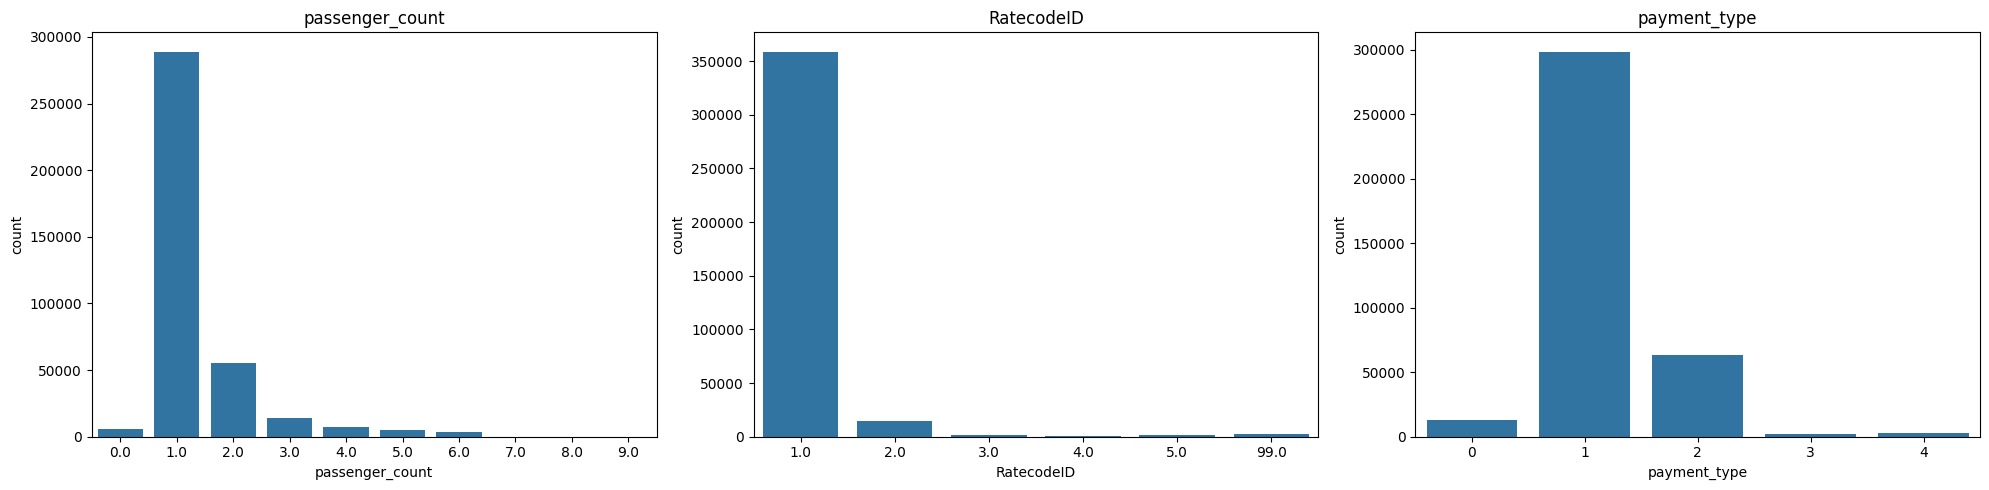

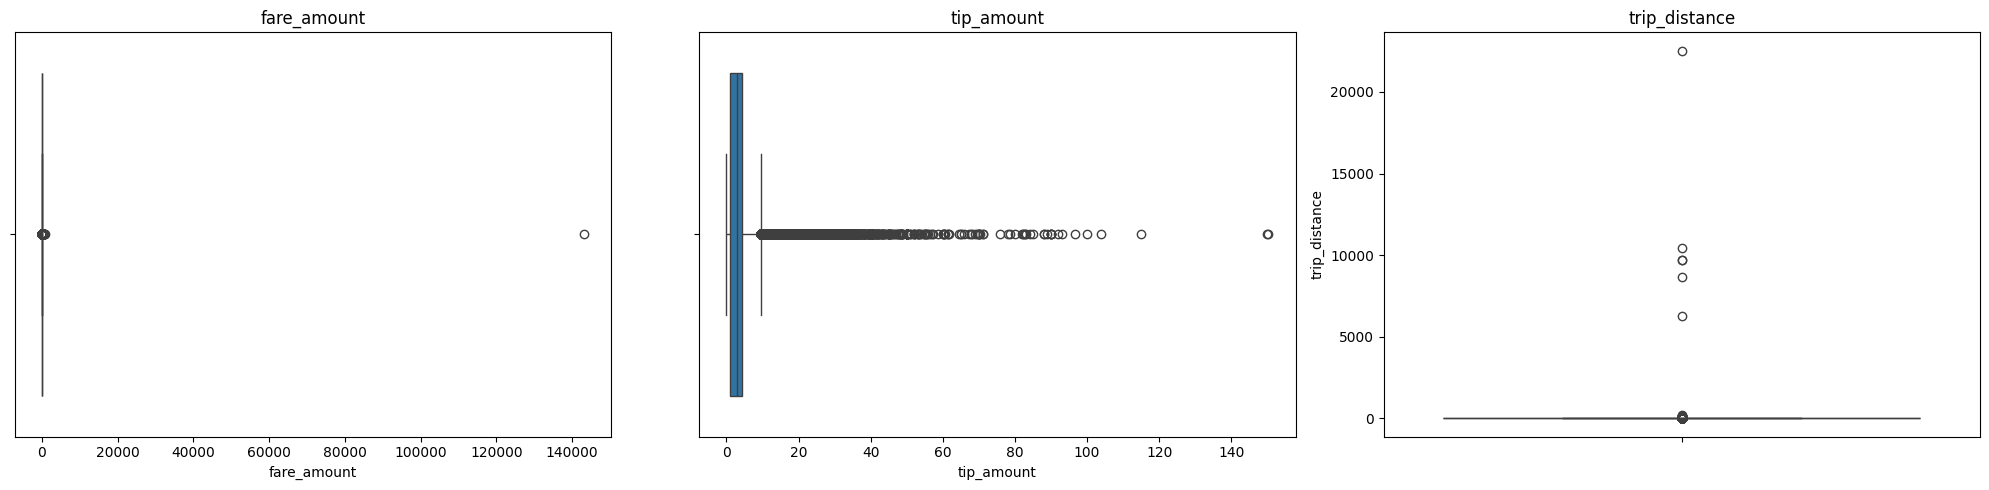

In [26]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title('passenger_count')
sns.countplot(x='passenger_count',data=combined_df) # there are less trips with >6 passengers
plt.subplot(1, 3, 2)
plt.title('RatecodeID')
sns.countplot(x=combined_df['RatecodeID']) # RatecodeID 1 is the most common value, and there are some records with RatecodeID 99, which is not a standard value.
plt.subplot(1, 3, 3)
plt.title('payment_type')
sns.countplot(x=combined_df['payment_type']) # Payment type 1 is the most common value, and there are some records with payment type 0, which is not a standard value.
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title('fare_amount')
sns.boxplot(x=combined_df['fare_amount']) # there are some outliers in fare_amount.
plt.subplot(1, 3, 2)
plt.title('tip_amount')
sns.boxplot(x=combined_df['tip_amount']) # tip_amount looks, however, there seems to be 1/2 outliers, which need to validated, if those records are good or bad
plt.subplot(1, 3, 3)
plt.title('trip_distance')
sns.boxplot(y=combined_df['trip_distance']) # there are some outliers in trip_distance
plt.tight_layout()
plt.show()

**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [27]:
# remove passenger_count > 6
combined_df.drop(combined_df[combined_df['passenger_count'] > 6].index, inplace = True)

In [28]:
# Continue with outlier handling
combined_df.drop(combined_df[combined_df['trip_distance'] > 250].index, inplace = True)
combined_df.drop(combined_df[combined_df['fare_amount'] > 300].index, inplace=True)
combined_df.drop(combined_df[combined_df['tip_amount'] > 100].index, inplace = True)

In [29]:
# Do any columns need standardising?
combined_df.drop(combined_df[(combined_df['payment_type'] == 0)].index, inplace=True)
combined_df.drop(combined_df[(combined_df['RatecodeID'] == 99)].index, inplace=True)
combined_df.drop(combined_df[(combined_df['trip_distance'] < 1) & (combined_df['fare_amount'] > 300)].index, inplace=True)
combined_df.drop(combined_df[(combined_df['trip_distance'] == 0) & (combined_df['fare_amount'] == 0) & (combined_df['PULocationID'] != combined_df['DOLocationID'])].index, inplace=True) 

## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [30]:
combined_df['pickup_day']=combined_df['tpep_pickup_datetime'].dt.day_name()
combined_df['dropoff_day']=combined_df['tpep_dropoff_datetime'].dt.day_name()
combined_df['pickup_hour']=combined_df['tpep_pickup_datetime'].dt.hour
combined_df['dropoff_hour']=combined_df['tpep_dropoff_datetime'].dt.hour
combined_df['pickup_month']=combined_df['tpep_pickup_datetime'].dt.month
combined_df['dropoff_month']=combined_df['tpep_dropoff_datetime'].dt.month
combined_df['dropoff_quater']=combined_df['tpep_dropoff_datetime'].dt.quarter
combined_df['pickup_quater']=combined_df['tpep_pickup_datetime'].dt.quarter
combined_df['trip_duration']=(combined_df['tpep_dropoff_datetime'] - combined_df['tpep_pickup_datetime']).dt.seconds

In [31]:
# Function to categorize the time of day
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'
    
combined_df['pickup_timeofday']=combined_df['pickup_hour'].apply(time_of_day)
combined_df['dropoff_timeofday']=combined_df['dropoff_hour'].apply(time_of_day)

In [32]:
df.columns.tolist()

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`: Categorical
* `tpep_pickup_datetime`: Numerical
* `tpep_dropoff_datetime`: Numerical
* `passenger_count`: Categorical
* `trip_distance`: Numerical
* `RatecodeID`: Categorical
* `PULocationID`: Numerical
* `DOLocationID`: Numerical
* `payment_type`: Categorical
* `pickup_hour`: Numerical
* `trip_duration`: Numerical


The following monetary parameters belong in the same category, is it categorical or numerical? Ans - Numerical


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

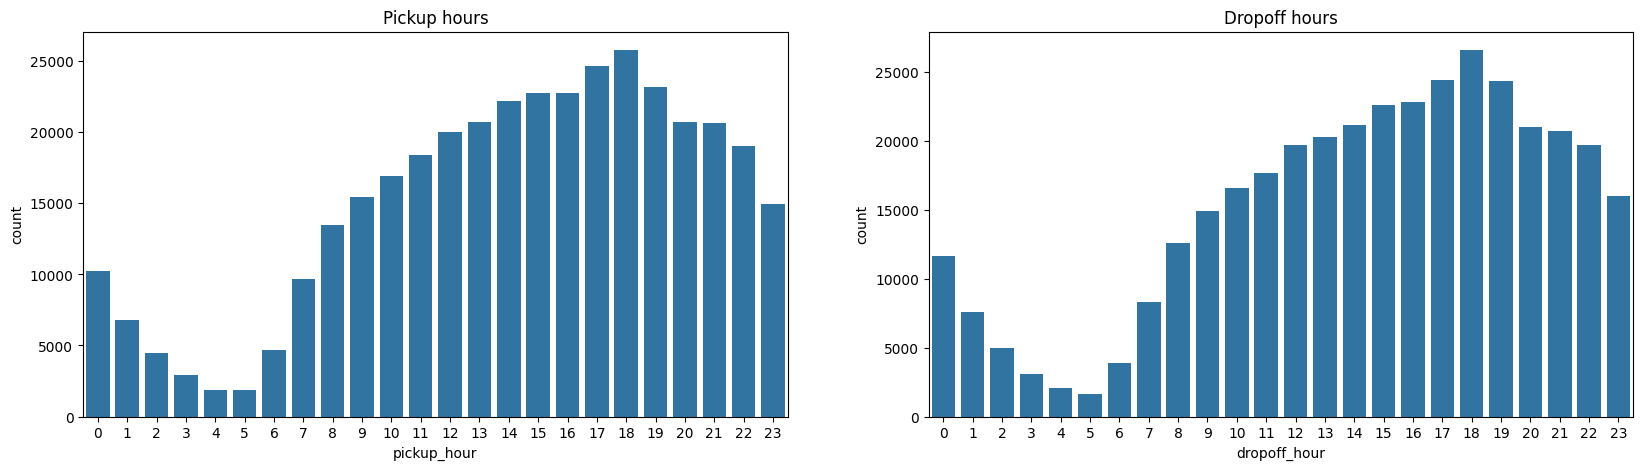

In [33]:
# Find and show the hourly trends in taxi pickups
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup hours')
ax=sns.countplot(x="pickup_hour",data=combined_df,ax=ax1)
ax2.set_title('Dropoff hours')
ax=sns.countplot(x="dropoff_hour",data=combined_df,ax=ax2)

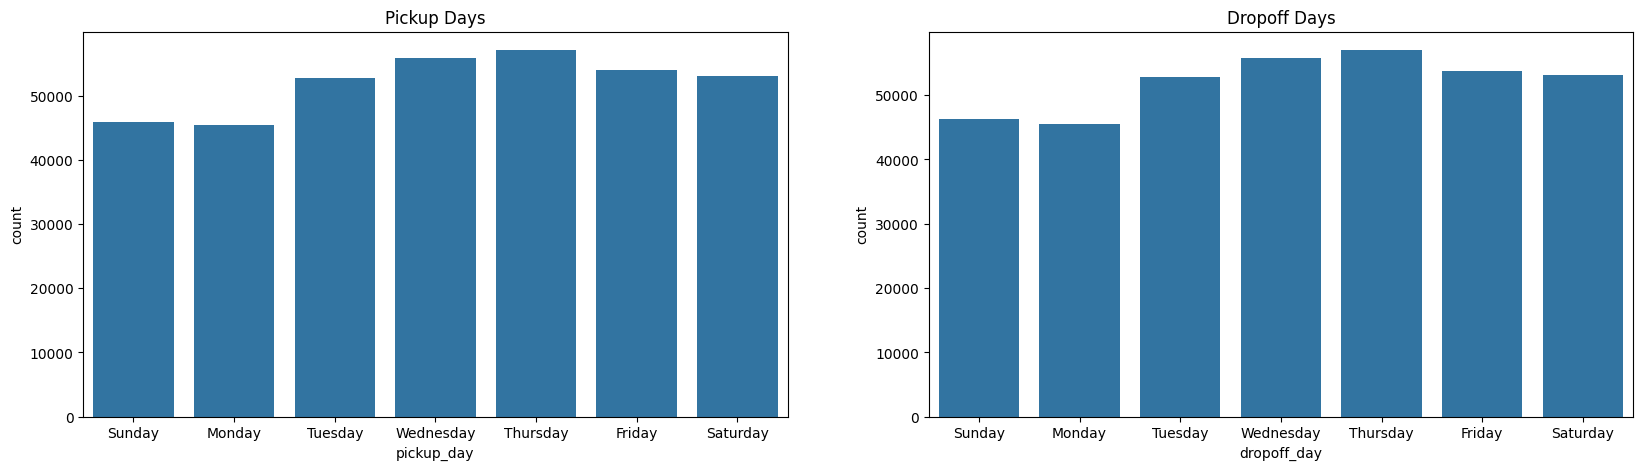

In [34]:
# Find and show the daily trends in taxi pickups (days of the week)
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))
ax3.set_title('Pickup Days')
ax=sns.countplot(x="pickup_day",data=combined_df,ax=ax3)
ax4.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day",data=combined_df,ax=ax4)

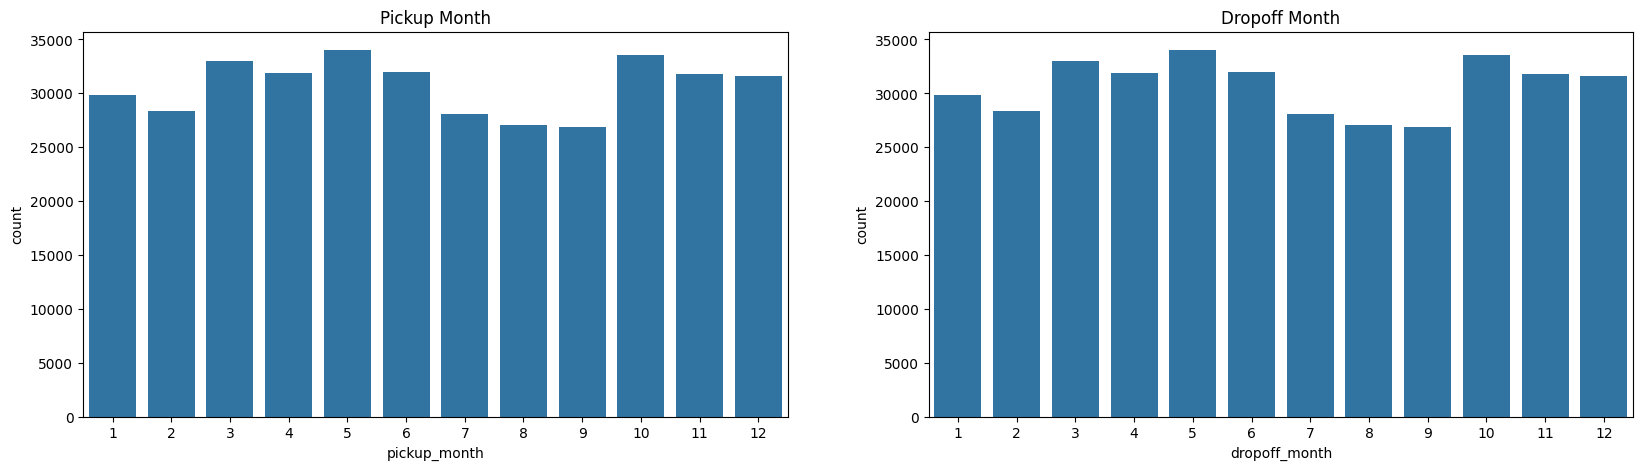

In [70]:
# Show the monthly trends in pickups
figure,(ax5,ax6)=plt.subplots(ncols=2,figsize=(20,5))
ax5.set_title('Pickup Month')
ax=sns.countplot(x="pickup_month",data=combined_df,ax=ax5)
ax6.set_title('Dropoff Month')
ax=sns.countplot(x="dropoff_month",data=combined_df,ax=ax6)

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

trip_distance vs fare_amount corr -  0.9110757854070516
trip_distance vs total_amount corr -  0.9107462650105814
trip_distance vs tip_amount corr -  0.5871705153330468


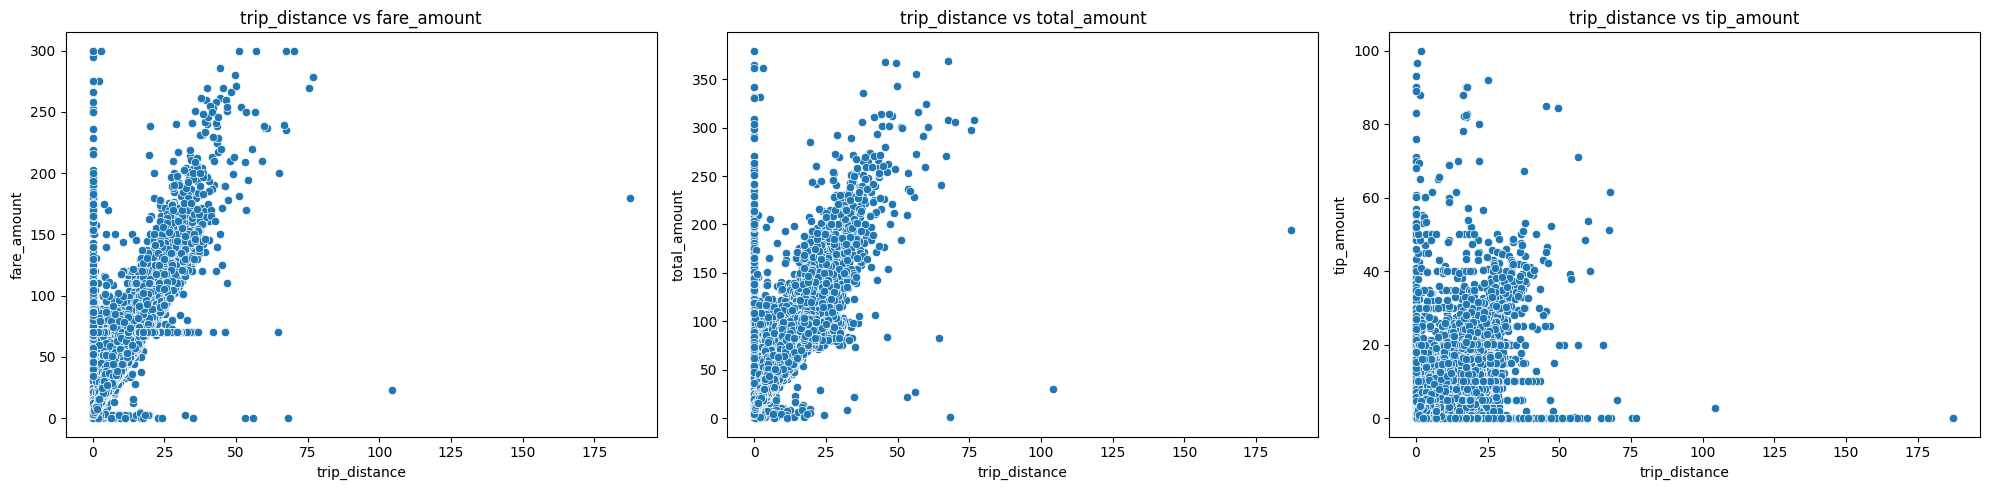

In [35]:
# Analyse the above parameters
print('trip_distance vs fare_amount corr - ',combined_df['trip_distance'].corr(combined_df['fare_amount'])) # High Positive Corrleation
print('trip_distance vs total_amount corr - ',combined_df['trip_distance'].corr(combined_df['total_amount'])) # High Positive Corrleation
print('trip_distance vs tip_amount corr - ',combined_df['trip_distance'].corr(combined_df['tip_amount'])) # Weak Positive Corrleation

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)

plt.title('trip_distance vs fare_amount')
sns.scatterplot(x="trip_distance",y="fare_amount",data=combined_df)
plt.subplot(1, 3, 2)

plt.title('trip_distance vs total_amount')
sns.scatterplot(x="trip_distance",y="total_amount", data=combined_df)
plt.subplot(1, 3, 3)

plt.title('trip_distance vs tip_amount')
sns.scatterplot(x="trip_distance",y="tip_amount",data=combined_df)
plt.tight_layout()
plt.show()

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [36]:
# Create a df with non zero entries for the selected parameters.
new_combined_df = combined_df[(combined_df['trip_distance'] > 0) & (combined_df['fare_amount'] > 0) & (combined_df['total_amount'] > 0) & (combined_df['tip_amount'] > 0)]
new_combined_df.reset_index(drop=True, inplace=True)
new_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282890 entries, 0 to 282889
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               282890 non-null  int64         
 1   tpep_pickup_datetime   282890 non-null  datetime64[us]
 2   tpep_dropoff_datetime  282890 non-null  datetime64[us]
 3   passenger_count        282890 non-null  float64       
 4   trip_distance          282890 non-null  float64       
 5   RatecodeID             282890 non-null  float64       
 6   PULocationID           282890 non-null  int64         
 7   DOLocationID           282890 non-null  int64         
 8   payment_type           282890 non-null  int64         
 9   fare_amount            282890 non-null  float64       
 10  extra                  282890 non-null  float64       
 11  mta_tax                282890 non-null  float64       
 12  tip_amount             282890 non-null  floa

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

    pickup_month  Total Revenue
9             10      798665.39
4              5      787517.05
10            11      739509.48
2              3      736577.03
5              6      732036.61
11            12      715991.78
3              4      710886.63
0              1      647026.26
8              9      636842.59
1              2      617165.59
6              7      614791.79
7              8      600215.97


<Axes: xlabel='pickup_month'>

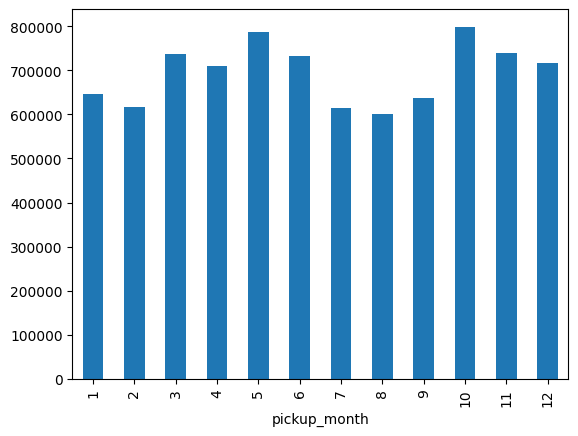

In [37]:
# Group data by month and analyse monthly revenue
print(new_combined_df.groupby('pickup_month')['total_amount'].sum().reset_index(name='Total Revenue').sort_values(by='Total Revenue',ascending=False))
new_combined_df.groupby('pickup_month')['total_amount'].sum().plot(kind='bar')

**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

   pickup_quater  Total Revenue
3              4     2254166.65
1              2     2230440.29
0              1     2000768.88
2              3     1851850.35


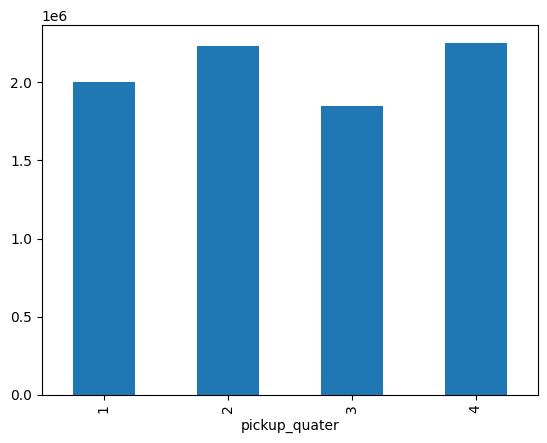

In [38]:
# Calculate proportion of each quarter
print(new_combined_df.groupby('pickup_quater')['total_amount'].sum().reset_index(name='Total Revenue').sort_values(by='Total Revenue',ascending=False))
ax = new_combined_df.groupby('pickup_quater')['total_amount'].sum().plot(kind='bar')

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

Correlation :  0.949452438423647


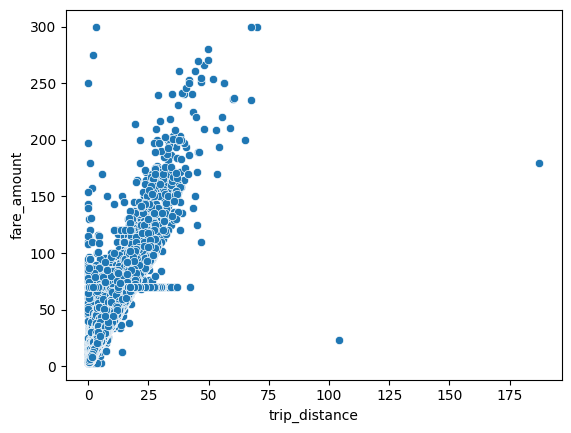

In [39]:
# Show how trip fare is affected by distance
print('Correlation : ', (new_combined_df['trip_distance'].corr(new_combined_df['fare_amount']))) 
sns.scatterplot(x="trip_distance",y="fare_amount",data=new_combined_df)
plt.show()

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

Correlation :  0.3312656984493615


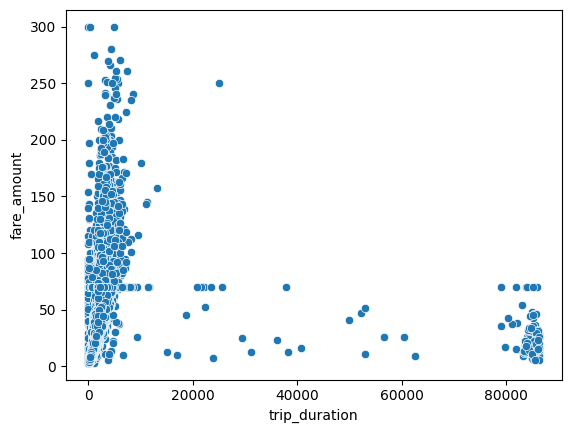

In [40]:
# Show relationship between fare and trip duration
print('Correlation : ', (new_combined_df['trip_duration'].corr(new_combined_df['fare_amount'])))

sns.scatterplot(x="trip_duration",y="fare_amount",data=new_combined_df)
plt.show()

   passenger_count  fare_amount
4              4.0    21.826221
2              2.0    21.680695
3              3.0    21.249770
6              6.0    18.786972
1              1.0    18.723883
5              5.0    18.625571
0              0.0    16.790184


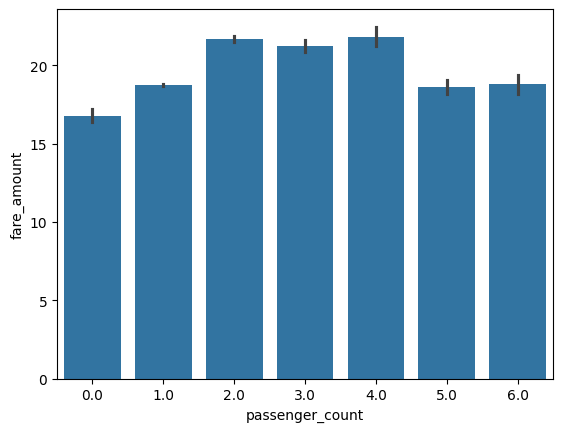

In [40]:
# Show relationship between fare and number of passengers
print(new_combined_df.groupby(['passenger_count'])['fare_amount'].mean().reset_index().sort_values(by='fare_amount',ascending=False))
sns.barplot(x="passenger_count",y="fare_amount",data=new_combined_df, estimator=np.mean)
plt.show()

Correlation :  0.8022050206344665


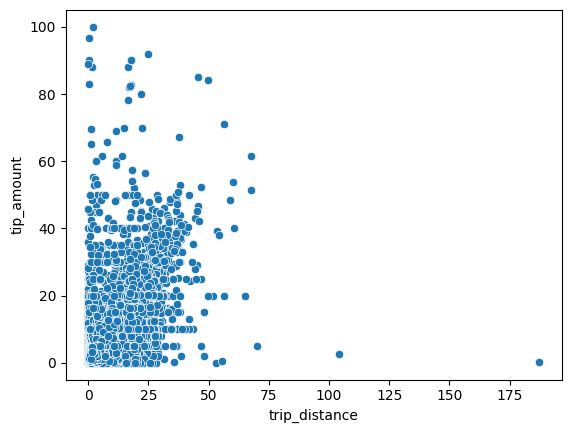

In [41]:
# Show relationship between tip and trip distance
print('Correlation : ', (new_combined_df['trip_distance'].corr(new_combined_df['tip_amount'])))

sns.scatterplot(x="trip_distance",y="tip_amount",data=new_combined_df)
plt.show()

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

payment_type
Credit card    282879
Dispute             5
Cash                5
No charge           1
Name: count, dtype: int64

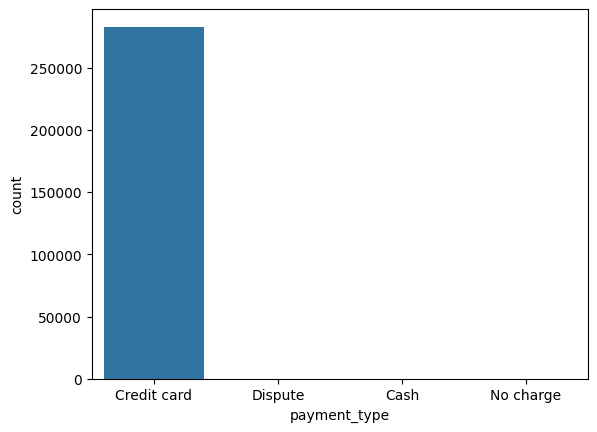

In [42]:
# Analyse the distribution of different payment types (payment_type).
def payment_type(x):
    if x == 1:
        return 'Credit card'
    elif x == 2:
        return 'Cash'
    elif x == 3:
        return 'No charge'
    elif x == 4:
        return 'Dispute'
    elif x == 5:
        return 'Unknown'
    elif x == 6:
        return 'Voided trip'

new_combined_df['payment_type'] = new_combined_df['payment_type'].apply(payment_type)

display(new_combined_df['payment_type'].value_counts())

sns.countplot(x="payment_type",data=new_combined_df)
plt.show()

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [43]:
!pip install geopandas

Defaulting to user installation because normal site-packages is not writeable


**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [43]:
import geopandas as gpd

# Read the shapefile using geopandas
zones = gpd.read_file('taxi_zones.shx') # read the .shp file using gpd
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

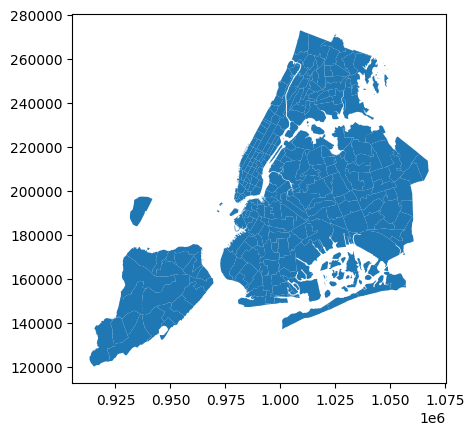

In [44]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [45]:
# Merge zones and trip records using locationID and PULocationID
new_combined_df = new_combined_df.merge(zones, left_on='PULocationID', right_on='LocationID', how='left')

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [46]:
# Group data by location and calculate the number of trips
pickup_location = new_combined_df.groupby(['zone','PULocationID']).size().reset_index(name='Number_of_trips')
pickup_location.sort_values(by='Number_of_trips', ascending=False, inplace=True)
pickup_location.head(10)

,zone,PULocationID,Number_of_trips
149,Upper East Side South,237,14076
97,Midtown Center,161,13421
148,Upper East Side North,236,12788
72,JFK Airport,132,12780
98,Midtown East,162,10660
80,LaGuardia Airport,138,10217
83,Lincoln Square East,142,9708
112,Penn Station/Madison Sq West,186,9677
143,Times Sq/Theatre District,230,8830
106,Murray Hill,170,8616


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [47]:
# Merge trip counts back to the zones GeoDataFrame
zones = zones.merge(pickup_location, left_on='zone', right_on='zone', how='left')
zones.sort_values(by='Number_of_trips', ascending=False).head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,Number_of_trips
236,237,0.042213,0.000096,Upper East Side South,237,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",237.0,14076.0
160,161,0.035804,0.000072,Midtown Center,161,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",161.0,13421.0
235,236,0.044252,0.000103,Upper East Side North,236,Manhattan,"POLYGON ((995940.048 221122.92, 995812.322 220...",236.0,12788.0
131,132,0.245479,0.002038,JFK Airport,132,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283...",132.0,12780.0
161,162,0.035270,0.000048,Midtown East,162,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21...",162.0,10660.0


The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

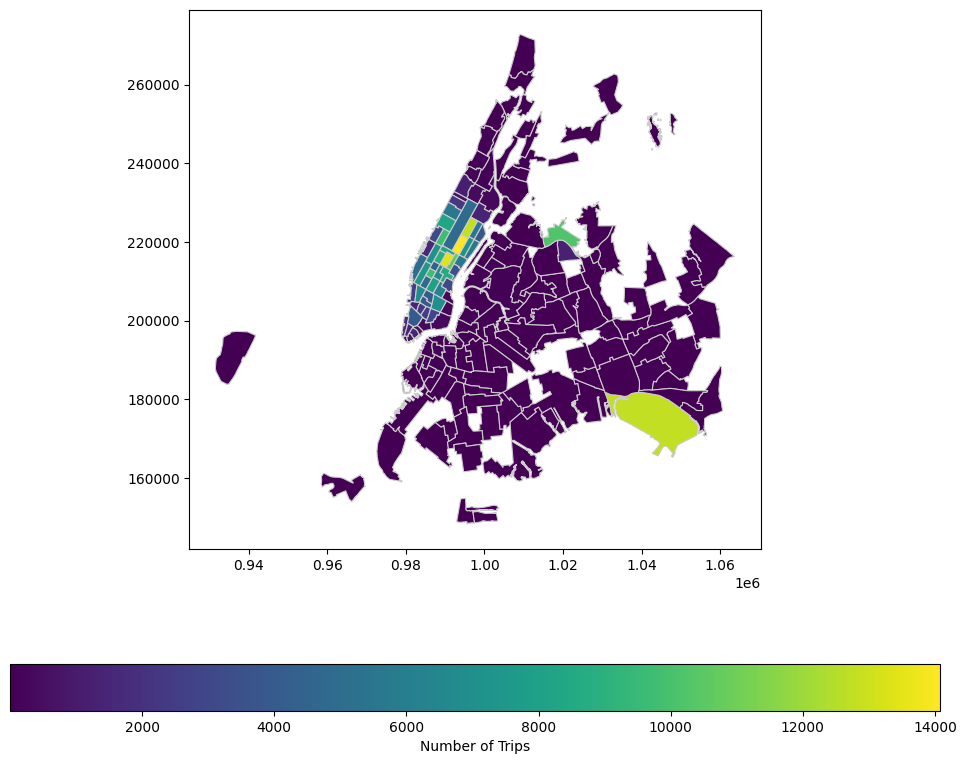

In [48]:
# Define figure and axis
fig, ax = plt.subplots(1, 1, figsize = (12, 10))

# Plot the map and display it
zones.plot(column='Number_of_trips', ax=ax, legend=True, legend_kwds = {'label': "Number of Trips", 'orientation': "horizontal"}, cmap='viridis', linewidth=0.8, edgecolor='0.8')
plt.show()

In [49]:
# can you try displaying the zones DF sorted by the number of trips?
zones.sort_values(by='Number_of_trips', ascending=False, inplace=True)
zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,PULocationID,Number_of_trips
236,237,0.042213,0.000096,Upper East Side South,237,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21...",237.0,14076.0
160,161,0.035804,0.000072,Midtown Center,161,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21...",161.0,13421.0
235,236,0.044252,0.000103,Upper East Side North,236,Manhattan,"POLYGON ((995940.048 221122.92, 995812.322 220...",236.0,12788.0
131,132,0.245479,0.002038,JFK Airport,132,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283...",132.0,12780.0
161,162,0.035270,0.000048,Midtown East,162,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21...",162.0,10660.0


Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [50]:
# Find routes which have the slowest speeds at different times of the day
new_combined_df.rename(columns={'zone': 'pickup_zone'}, inplace=True)
new_combined_df.drop(columns=['LocationID'], inplace=True)

# Merge to get drop off zone
new_combined_df = new_combined_df.merge(zones[['LocationID', 'zone']], left_on='DOLocationID', right_on='LocationID', how='left')
new_combined_df.rename(columns={'zone': 'dropoff_zone'}, inplace=True)
new_combined_df.drop(columns=['LocationID'], inplace=True)

new_combined_df['speed'] = new_combined_df['trip_distance']/(new_combined_df['trip_duration']/3600)
slow_routes_df = new_combined_df.groupby(['pickup_zone','PULocationID','dropoff_zone', 'DOLocationID', 'pickup_hour'])['speed'].mean().reset_index()

slow_routes_df = slow_routes_df.sort_values(by='speed', ascending=True).reset_index(drop=True)

# top 10 slowest routes by average speed
slow_routes_df.head(10)

,pickup_zone,PULocationID,dropoff_zone,DOLocationID,pickup_hour,speed
0,Seaport,209,Two Bridges/Seward Park,232,13,0.043579
1,East Elmhurst,70,LaGuardia Airport,138,6,0.085750
2,Seaport,209,Boerum Hill,25,22,0.106057
3,Midtown Center,161,Upper West Side North,238,7,0.117807
4,Midtown North,163,Financial District North,87,15,0.140078
5,Williamsburg (North Side),255,Williamsburg (South Side),256,2,0.141176
6,Queensbridge/Ravenswood,193,Queensbridge/Ravenswood,193,11,0.150000
7,Greenwich Village North,113,Park Slope,181,19,0.153191
8,Sutton Place/Turtle Bay North,229,Central Harlem,41,17,0.174780
9,Upper West Side North,238,West Village,249,1,0.196820


How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

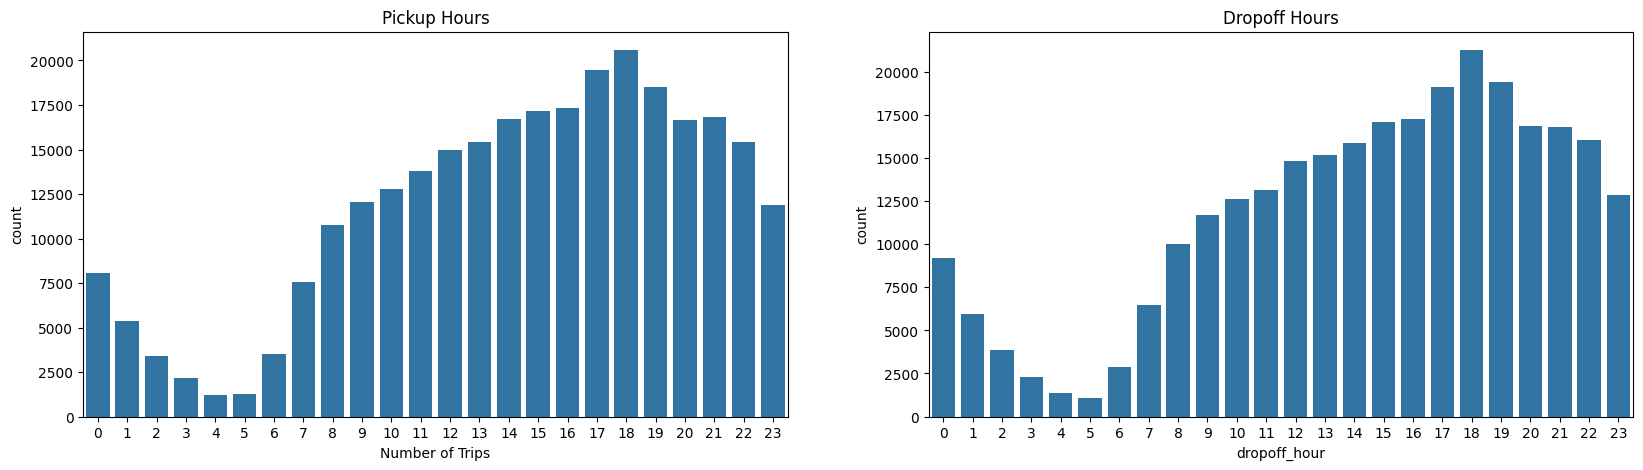

In [51]:
# Visualise the number of trips per hour and find the busiest hour
figure,(ax7,ax8)=plt.subplots(ncols=2,figsize=(20,5))
ax7.set_title('Pickup Hours')
ax7.set_xlabel("Number of Trips")

ax=sns.countplot(x="pickup_hour",data=new_combined_df,ax=ax7)
ax8.set_title('Dropoff Hours')
ax=sns.countplot(x="dropoff_hour",data=new_combined_df,ax=ax8)

Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [52]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.01

hourly_trips = new_combined_df['pickup_hour'].value_counts().sort_index() # Calculate the number of trips at each hour of the day
act_hrly_trp = hourly_trips / sample_fraction
act_hrly_trp.sort_values(ascending=False).head(5).reset_index(name="Number of trips") 

,pickup_hour,Number of trips
0,18,2059300.0
1,17,1948000.0
2,19,1850700.0
3,16,1732600.0
4,15,1716400.0


**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

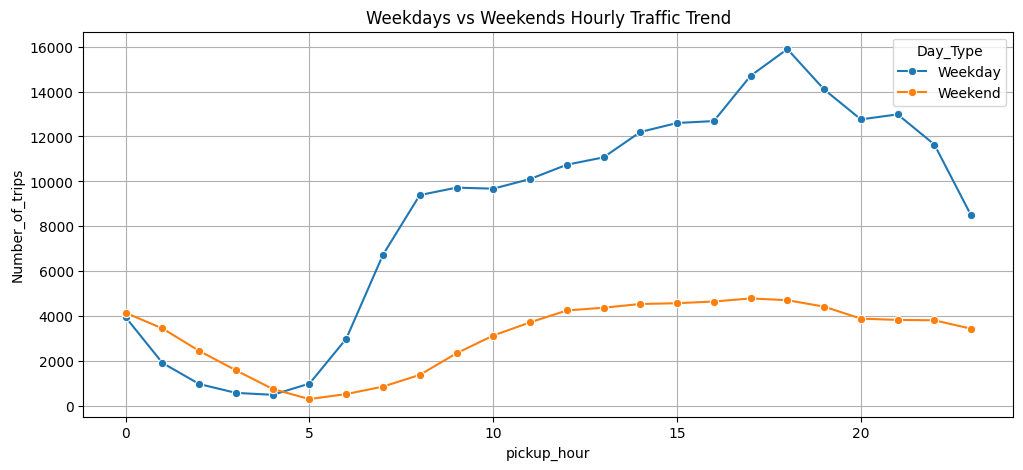

In [53]:
# Compare traffic trends for the week days and weekends
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday']
weekends = ['Saturday','Sunday']

weekday_trips = new_combined_df[new_combined_df['pickup_day'].isin(weekdays)]['pickup_hour'].value_counts()
weekend_trips = new_combined_df[new_combined_df['pickup_day'].isin(weekends)]['pickup_hour'].value_counts()

weekday_trips_df = weekday_trips.reset_index()
weekday_trips_df.columns = ['pickup_hour', 'Number_of_trips']
weekday_trips_df['Day_Type'] = 'Weekday'

weekend_trips_df = weekend_trips.reset_index()
weekend_trips_df.columns = ['pickup_hour', 'Number_of_trips']
weekend_trips_df['Day_Type'] = 'Weekend'

combined_trips_df = pd.concat([weekday_trips_df, weekend_trips_df])

plt.figure(figsize=(12, 5))
sns.lineplot(data=combined_trips_df, x='pickup_hour', y='Number_of_trips', hue='Day_Type', marker='o')
plt.title('Weekdays vs Weekends Hourly Traffic Trend')
plt.grid(True)
plt.show()

What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [54]:
# Find top 10 pickup and dropoff zones
top_10_high_pickup_zones_df = new_combined_df.groupby(['pickup_zone', 'pickup_hour']).size().reset_index(name='Number_of_trips')
top_10_high_pickup_zones_df = top_10_high_pickup_zones_df.sort_values(by='Number_of_trips', ascending=False).head(10)
top_10_high_pickup_zones = top_10_high_pickup_zones_df['pickup_zone'].unique()

top_10_high_dropoff_zones_df = new_combined_df.groupby(['dropoff_zone', 'dropoff_hour']).size().reset_index(name='Number_of_trips')
top_10_high_dropoff_zones_df = top_10_high_dropoff_zones_df.sort_values(by='Number_of_trips', ascending=False).head(10)
top_10_high_dropoff_zones = top_10_high_dropoff_zones_df['dropoff_zone'].unique()

print("Top 10 Pickup Zones:")
display(top_10_high_pickup_zones_df)

print("\nTop 10 Dropoff zones:")
display(top_10_high_dropoff_zones_df)

Top 10 Pickup Zones:


,pickup_zone,pickup_hour,Number_of_trips
1298,Midtown Center,18,1217
1297,Midtown Center,17,1203
1903,Upper East Side South,17,1125
1877,Upper East Side North,15,1068
1299,Midtown Center,19,1062
1901,Upper East Side South,15,1060
1904,Upper East Side South,18,1050
1900,Upper East Side South,14,1040
1902,Upper East Side South,16,1017
913,JFK Airport,22,992



Top 10 Dropoff zones:


,dropoff_zone,dropoff_hour,Number_of_trips
3611,Upper East Side South,18,1058
3587,Upper East Side North,18,1044
3584,Upper East Side North,15,1034
3585,Upper East Side North,16,1003
3586,Upper East Side North,17,1000
3605,Upper East Side South,12,952
3608,Upper East Side South,15,934
3607,Upper East Side South,14,919
3610,Upper East Side South,17,915
3588,Upper East Side North,19,890


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [55]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
pickup_trip_counts = new_combined_df['pickup_zone'].value_counts().reset_index()
pickup_trip_counts.columns = ['zone', 'pickup_trip_counts']

dropoff_trip_counts = new_combined_df['dropoff_zone'].value_counts().reset_index()
dropoff_trip_counts.columns = ['zone', 'dropoff_trip_counts']

zone_counts = pd.merge(pickup_trip_counts, dropoff_trip_counts, on='zone', how='outer').fillna(0) # Merged the pickup and drop off zones dataframe

# Calculate the ratio of pickups to dropoffs
zone_counts['pickup_dropoff_ratio'] = zone_counts['pickup_trip_counts'] / zone_counts['dropoff_trip_counts']

# Display the 10 highest and 10 lowest pickup/dropoff ratios
zone_counts = zone_counts[zone_counts.pickup_dropoff_ratio != np.inf]
highest_ratios = zone_counts.sort_values(by='pickup_dropoff_ratio', ascending=False).head(10)
lowest_ratios = zone_counts[zone_counts['pickup_trip_counts'] > 0].sort_values(by='pickup_dropoff_ratio', ascending=True).head(10)

print("Top 10 Highest Pickup/Dropoff Ratios:")
display(highest_ratios)

print("\nTop 10 Lowest Pickup/Dropoff Ratios:")
display(lowest_ratios)


Top 10 Highest Pickup/Dropoff Ratios:


,zone,pickup_trip_counts,dropoff_trip_counts,pickup_dropoff_ratio
63,East Elmhurst,1284.0,92,13.956522
116,JFK Airport,12793.0,2668,4.794978
125,LaGuardia Airport,10224.0,3519,2.905371
201,South Jamaica,27.0,15,1.800000
174,Penn Station/Madison Sq West,9678.0,6001,1.612731
39,Central Park,4889.0,3460,1.413006
235,West Village,6894.0,5062,1.361912
101,Greenwich Village South,3855.0,2881,1.338077
149,Midtown East,10660.0,8250,1.292121
91,Garment District,4261.0,3503,1.216386



Top 10 Lowest Pickup/Dropoff Ratios:


,zone,pickup_trip_counts,dropoff_trip_counts,pickup_dropoff_ratio
11,Bay Ridge,1.0,152,0.006579
160,Newark Airport,6.0,742,0.008086
211,Stuyvesant Heights,2.0,206,0.009709
206,Spuyten Duyvil/Kingsbridge,1.0,91,0.010989
54,Crown Heights North,5.0,387,0.012920
229,Washington Heights North,6.0,461,0.013015
185,Ridgewood,2.0,119,0.016807
84,Flushing,2.0,105,0.019048
183,Rego Park,1.0,51,0.019608
14,Bedford,5.0,255,0.019608


**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

'Top 10 pickup zones during night hours'

,pickup_zone,Trip Count
0,East Village,2566
1,West Village,2141
2,JFK Airport,1937
3,Lower East Side,1612
4,Clinton East,1565
5,Greenwich Village South,1394
6,Times Sq/Theatre District,1250
7,Penn Station/Madison Sq West,1050
8,LaGuardia Airport,983
9,East Chelsea,939


'Top 10 dropoff zones during night hours'

,dropoff_zone,Trip Count
0,East Village,1386
1,Clinton East,1073
2,Murray Hill,1048
3,Gramercy,970
4,Lenox Hill West,924
5,East Chelsea,899
6,Yorkville West,867
7,West Village,798
8,Upper East Side North,761
9,Sutton Place/Turtle Bay North,738


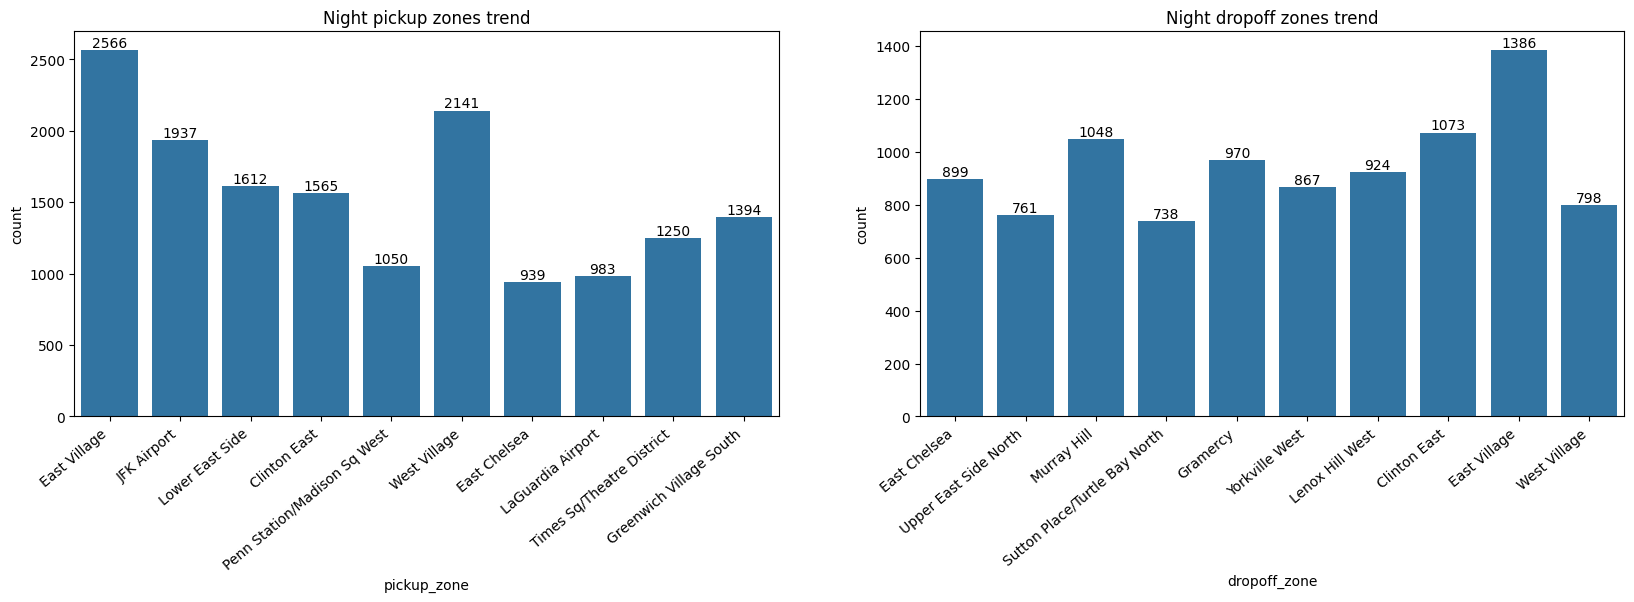

In [56]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
night_hours = [23, 0, 1, 2, 3, 4, 5]
day_trips = new_combined_df[~new_combined_df['pickup_hour'].isin(night_hours)]
night_trips = new_combined_df[new_combined_df['pickup_hour'].isin(night_hours)]
night_pickup_zones = night_trips['pickup_zone'].value_counts().head(10).index
night_dropoff_zones = night_trips['dropoff_zone'].value_counts().head(10).index

display('Top 10 pickup zones during night hours', night_trips['pickup_zone'].value_counts().reset_index(name='Trip Count').head(10))
display('Top 10 dropoff zones during night hours', night_trips['dropoff_zone'].value_counts().reset_index(name='Trip Count').head(10))


figure,(ax13,ax14)=plt.subplots(ncols=2,figsize=(20,5))
ax=sns.countplot(x="pickup_zone",data=night_trips[night_trips['pickup_zone'].isin(night_pickup_zones)],ax=ax13)
ax.bar_label(ax.containers[0])
ax13.set_title('Night pickup zones trend')
ax13.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax=sns.countplot(x="dropoff_zone",data=night_trips[night_trips['dropoff_zone'].isin(night_dropoff_zones)],ax=ax14)
ax.bar_label(ax.containers[0])
ax14.set_title('Night dropoff zones trend')
ax14.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()



Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

Nighttime Revenue Share: 11.98%
Daytime Revenue Share: 88.02%


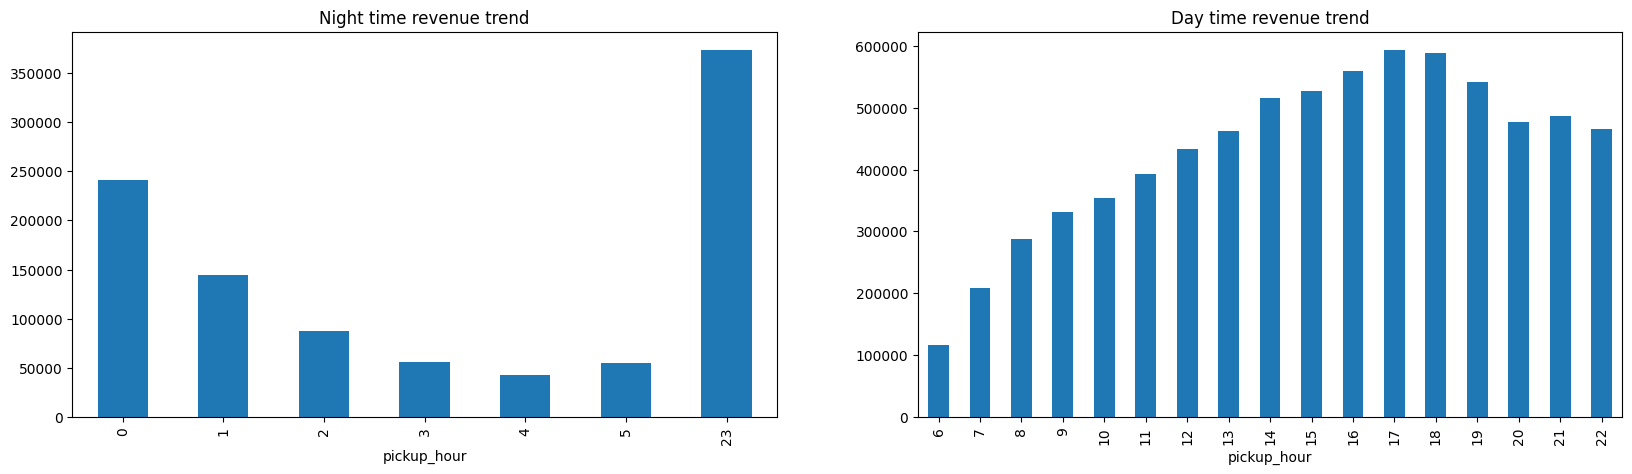

In [57]:
# Filter for night hours (11 PM to 5 AM)
night_revenue = night_trips['total_amount'].sum()
day_revenue = day_trips['total_amount'].sum()
total_revenue = night_revenue + day_revenue

night_revenue_share = (night_revenue / total_revenue) * 100
day_revenue_share = (day_revenue / total_revenue) * 100

print(f"Nighttime Revenue Share: {night_revenue_share:.2f}%")
print(f"Daytime Revenue Share: {day_revenue_share:.2f}%")

figure,(ax15,ax16)=plt.subplots(ncols=2,figsize=(20,5))
ax=night_trips.groupby('pickup_hour')['total_amount'].sum().plot(kind='bar',ax=ax15)
ax15.set_title('Night time revenue trend')
ax=day_trips.groupby('pickup_hour')['total_amount'].sum().plot(kind='bar',ax=ax16)
ax16.set_title('Day time revenue trend')
plt.show()

##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

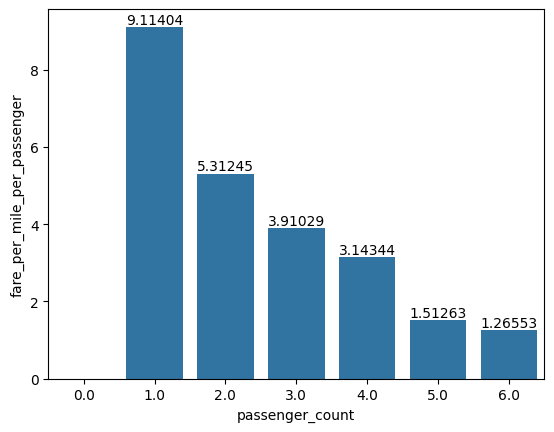

In [58]:
# Analyse the fare per mile per passenger for different passenger counts
new_combined_df['fare_per_mile'] = new_combined_df['fare_amount'] / new_combined_df['trip_distance']
new_combined_df['fare_per_mile_per_passenger'] = new_combined_df['fare_per_mile'] / new_combined_df['passenger_count']

average_fare_per_mile_per_passenger = new_combined_df.groupby('passenger_count')['fare_per_mile_per_passenger'].mean().reset_index()

ax = sns.barplot(x = 'passenger_count', y = 'fare_per_mile_per_passenger', data = average_fare_per_mile_per_passenger)
ax.bar_label(ax.containers[0])
plt.show()


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

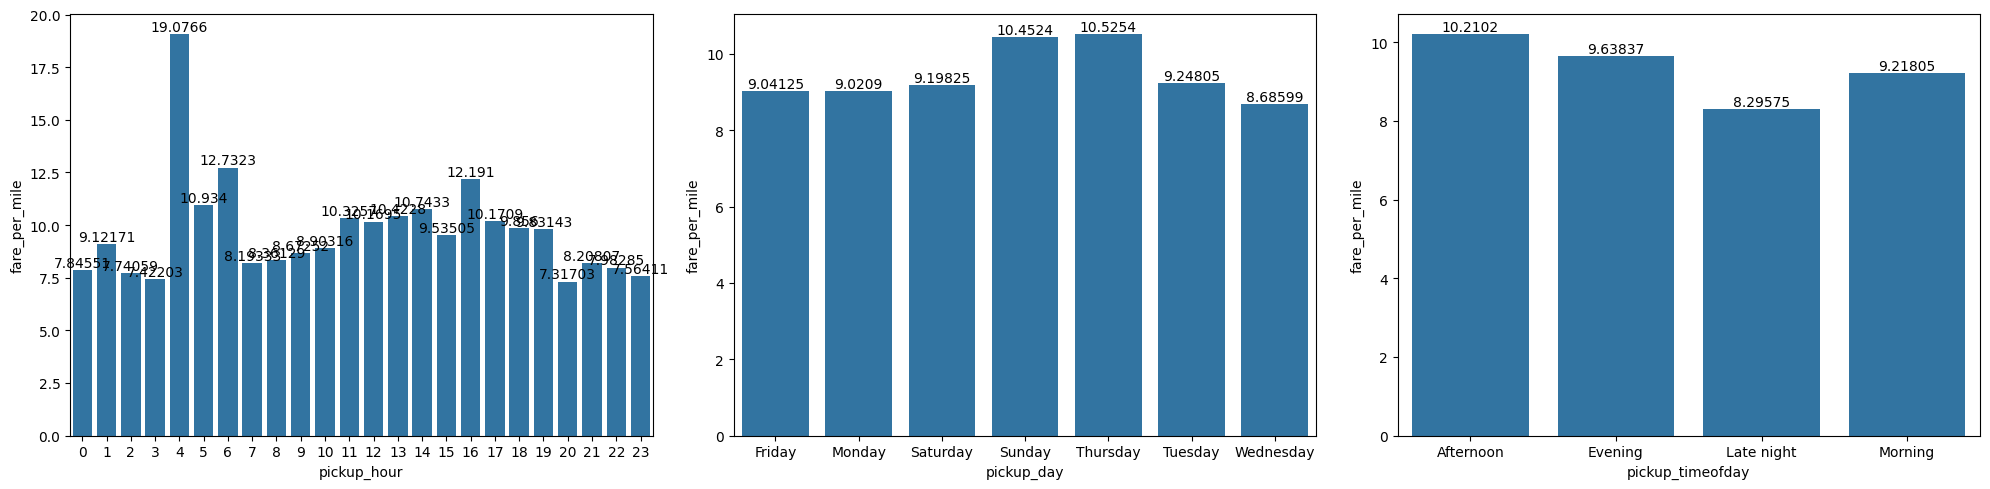

In [59]:
# Compare the average fare per mile for different days and for different times of the day

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
ax = sns.barplot(x='pickup_hour', y='fare_per_mile', data=new_combined_df.groupby('pickup_hour')['fare_per_mile'].mean().reset_index())
ax.bar_label(ax.containers[0])

plt.subplot(1, 3, 2)
ax = sns.barplot(x='pickup_day', y='fare_per_mile', data=new_combined_df.groupby('pickup_day')['fare_per_mile'].mean().reset_index())
ax.bar_label(ax.containers[0])

plt.subplot(1, 3, 3)
ax = sns.barplot(x='pickup_timeofday', y='fare_per_mile', data=new_combined_df.groupby('pickup_timeofday')['fare_per_mile'].mean().reset_index())
ax.bar_label(ax.containers[0])

plt.tight_layout()
plt.show()

**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

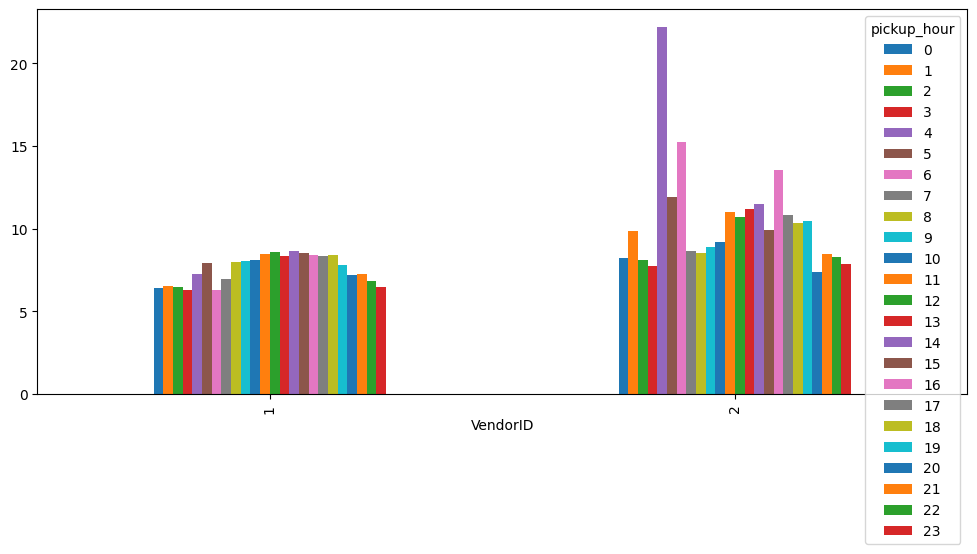

In [60]:
# Compare fare per mile for different vendors
far_per_mile_vendor = pd.pivot_table(data=new_combined_df,index='VendorID',columns='pickup_hour', values='fare_per_mile',aggfunc='mean').plot(kind='bar',figsize=(12,5))

df = new_combined_df[['VendorID','pickup_hour','fare_per_mile']].groupby(['VendorID','pickup_hour'])['fare_per_mile'].mean().reset_index(name="fare_per_mile")
plt.show()

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


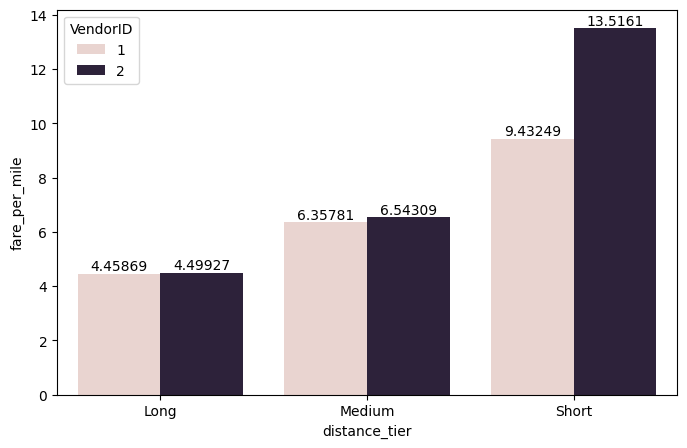

In [61]:
# Defining distance tiers
def distance_tier(distance):
    if distance <= 2:
        return 'Short'
    elif distance <= 5:
        return 'Medium'
    else:
        return 'Long'

new_combined_df['distance_tier'] = new_combined_df['trip_distance'].apply(distance_tier)
fare_per_mile_tiered = new_combined_df.groupby(['VendorID', 'distance_tier'])['fare_per_mile'].mean().reset_index()

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='distance_tier', y='fare_per_mile', hue='VendorID', data=fare_per_mile_tiered)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

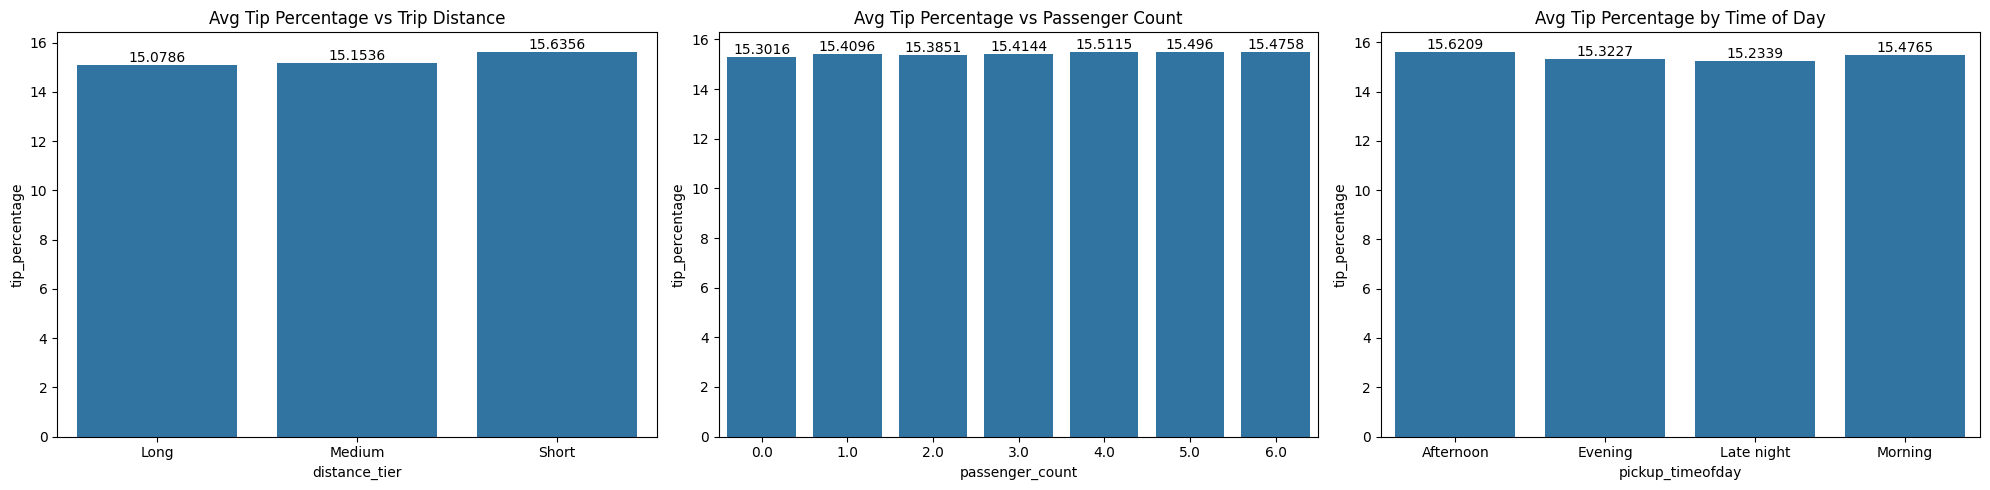

In [62]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
new_combined_df['tip_percentage'] = (new_combined_df['tip_amount'] / new_combined_df['total_amount']) * 100 # Calculate tip percentage

distance_tip_percentage = new_combined_df.groupby('distance_tier')['tip_percentage'].mean().reset_index() # trip distance vs trip percentage
passenger_tip_percentage = new_combined_df.groupby('passenger_count')['tip_percentage'].mean().reset_index() # passenger count vs trip percentage
time_tip_percentage = new_combined_df.groupby('pickup_timeofday')['tip_percentage'].mean().reset_index() # time of pickup vs trip percentage

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
ax = sns.barplot(x='distance_tier', y='tip_percentage', data=distance_tip_percentage)
ax.bar_label(ax.containers[0])
plt.title('Avg Tip Percentage vs Trip Distance')

plt.subplot(1, 3, 2)
ax = sns.barplot(x='passenger_count', y='tip_percentage', data=passenger_tip_percentage)
ax.bar_label(ax.containers[0])
plt.title('Avg Tip Percentage vs Passenger Count')

plt.subplot(1, 3, 3)
ax = sns.barplot(x='pickup_timeofday', y='tip_percentage', data=time_tip_percentage)
ax.bar_label(ax.containers[0])
plt.title('Avg Tip Percentage by Time of Day')

plt.tight_layout()
plt.show()

Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

Trip Distance Comparison:


,Low Tip,High Tip
count,41777.00000,241145.000000
mean,3.56569,3.380844
std,4.59189,4.336947
min,0.01000,0.010000
25%,1.19000,1.100000
50%,2.00000,1.800000
75%,3.55000,3.300000
max,187.35000,67.510000



Passenger Count Comparison:


,Low Tip,High Tip
count,41777.000000,241145.000000
mean,1.338583,1.356217
std,0.869938,0.880846
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,6.000000,6.000000



Fare Amount Comparison:


,Low Tip,High Tip
count,41777.000000,241145.000000
mean,20.122156,19.137167
std,17.863045,16.749824
min,3.000000,3.000000
25%,10.000000,9.300000
50%,14.900000,13.500000
75%,22.600000,21.200000
max,300.000000,300.000000


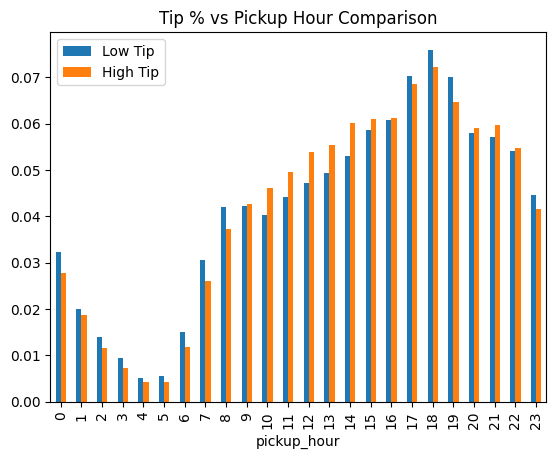

In [63]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%
new_combined_df['tip_category'] = new_combined_df['tip_percentage'].apply(lambda x: 'High Tip' if x > 10 else 'Low Tip') # tip_category based upon tip_percentage
low_tip_trips = new_combined_df[new_combined_df['tip_category'] == 'Low Tip']
high_tip_trips = new_combined_df[new_combined_df['tip_category'] == 'High Tip']

# Analyze trip distance
distance_comparison = pd.DataFrame({
    'Low Tip': low_tip_trips['trip_distance'].describe(),
    'High Tip': high_tip_trips['trip_distance'].describe()
})

# Analyze passenger count
passenger_count_comparison = pd.DataFrame({
    'Low Tip': low_tip_trips['passenger_count'].describe(),
    'High Tip': high_tip_trips['passenger_count'].describe()
})

# Analyze time of pickup
pickup_time_comparison = pd.DataFrame({
    'Low Tip': low_tip_trips['pickup_hour'].value_counts(normalize=True).sort_index(),
    'High Tip': high_tip_trips['pickup_hour'].value_counts(normalize=True).sort_index()
})

# Analyze fare amount
fare_amount_comparison = pd.DataFrame({
    'Low Tip': low_tip_trips['fare_amount'].describe(),
    'High Tip': high_tip_trips['fare_amount'].describe()
})

print("Trip Distance Comparison:")
display(distance_comparison)
print("\nPassenger Count Comparison:")
display(passenger_count_comparison)
print("\nFare Amount Comparison:")
display(fare_amount_comparison)

# display(pickup_time_comparison)

pickup_time_comparison.plot(kind='bar')
plt.title('Tip % vs Pickup Hour Comparison')
plt.show()

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

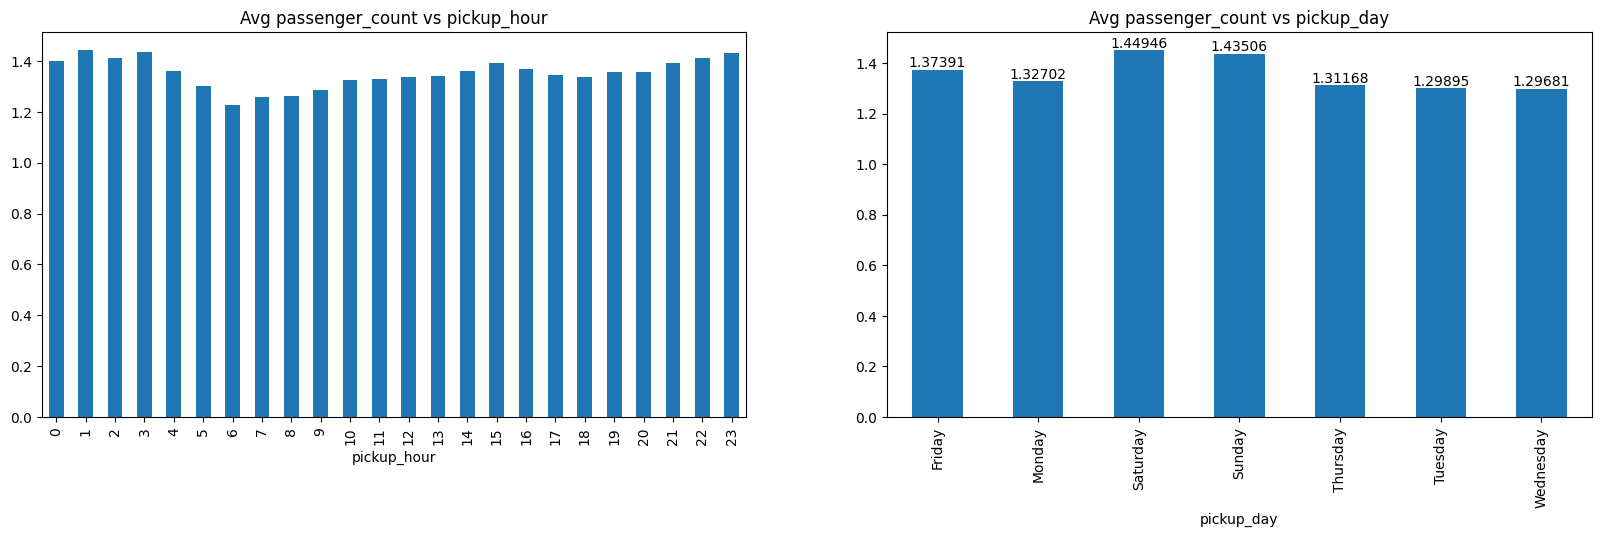

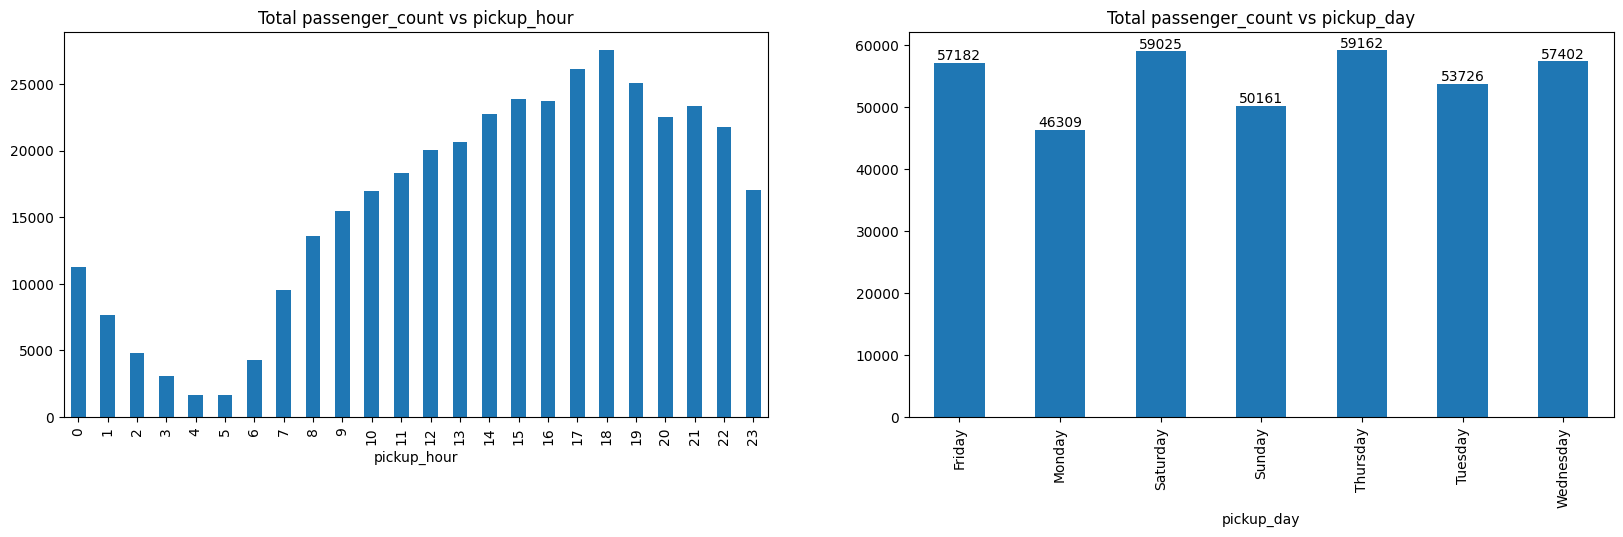

In [64]:
# See how passenger count varies across hours and days
figure,(ax19,ax20)=plt.subplots(ncols=2,figsize=(15,5))
ax19.set_title('Avg passenger_count vs pickup_hour')
ax = new_combined_df.groupby(['pickup_hour'])['passenger_count'].mean().plot(kind='bar', figsize=(20, 5), ax=ax19)
ax20.set_title('Avg passenger_count vs pickup_day')
ax = new_combined_df.groupby(['pickup_day'])['passenger_count'].mean().plot(kind='bar', figsize=(20, 5),ax=ax20)
ax.bar_label(ax.containers[0])
plt.show()

figure,(ax21,ax22)=plt.subplots(ncols=2,figsize=(15,5))
ax21.set_title('Total passenger_count vs pickup_hour')
ax = new_combined_df.groupby(['pickup_hour'])['passenger_count'].sum().plot(kind='bar', figsize=(20, 5), ax=ax21)
ax22.set_title('Total passenger_count vs pickup_day')
ax = new_combined_df.groupby(['pickup_day'])['passenger_count'].sum().plot(kind='bar', figsize=(20, 5),ax=ax22)
ax.bar_label(ax.containers[0])
plt.show()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

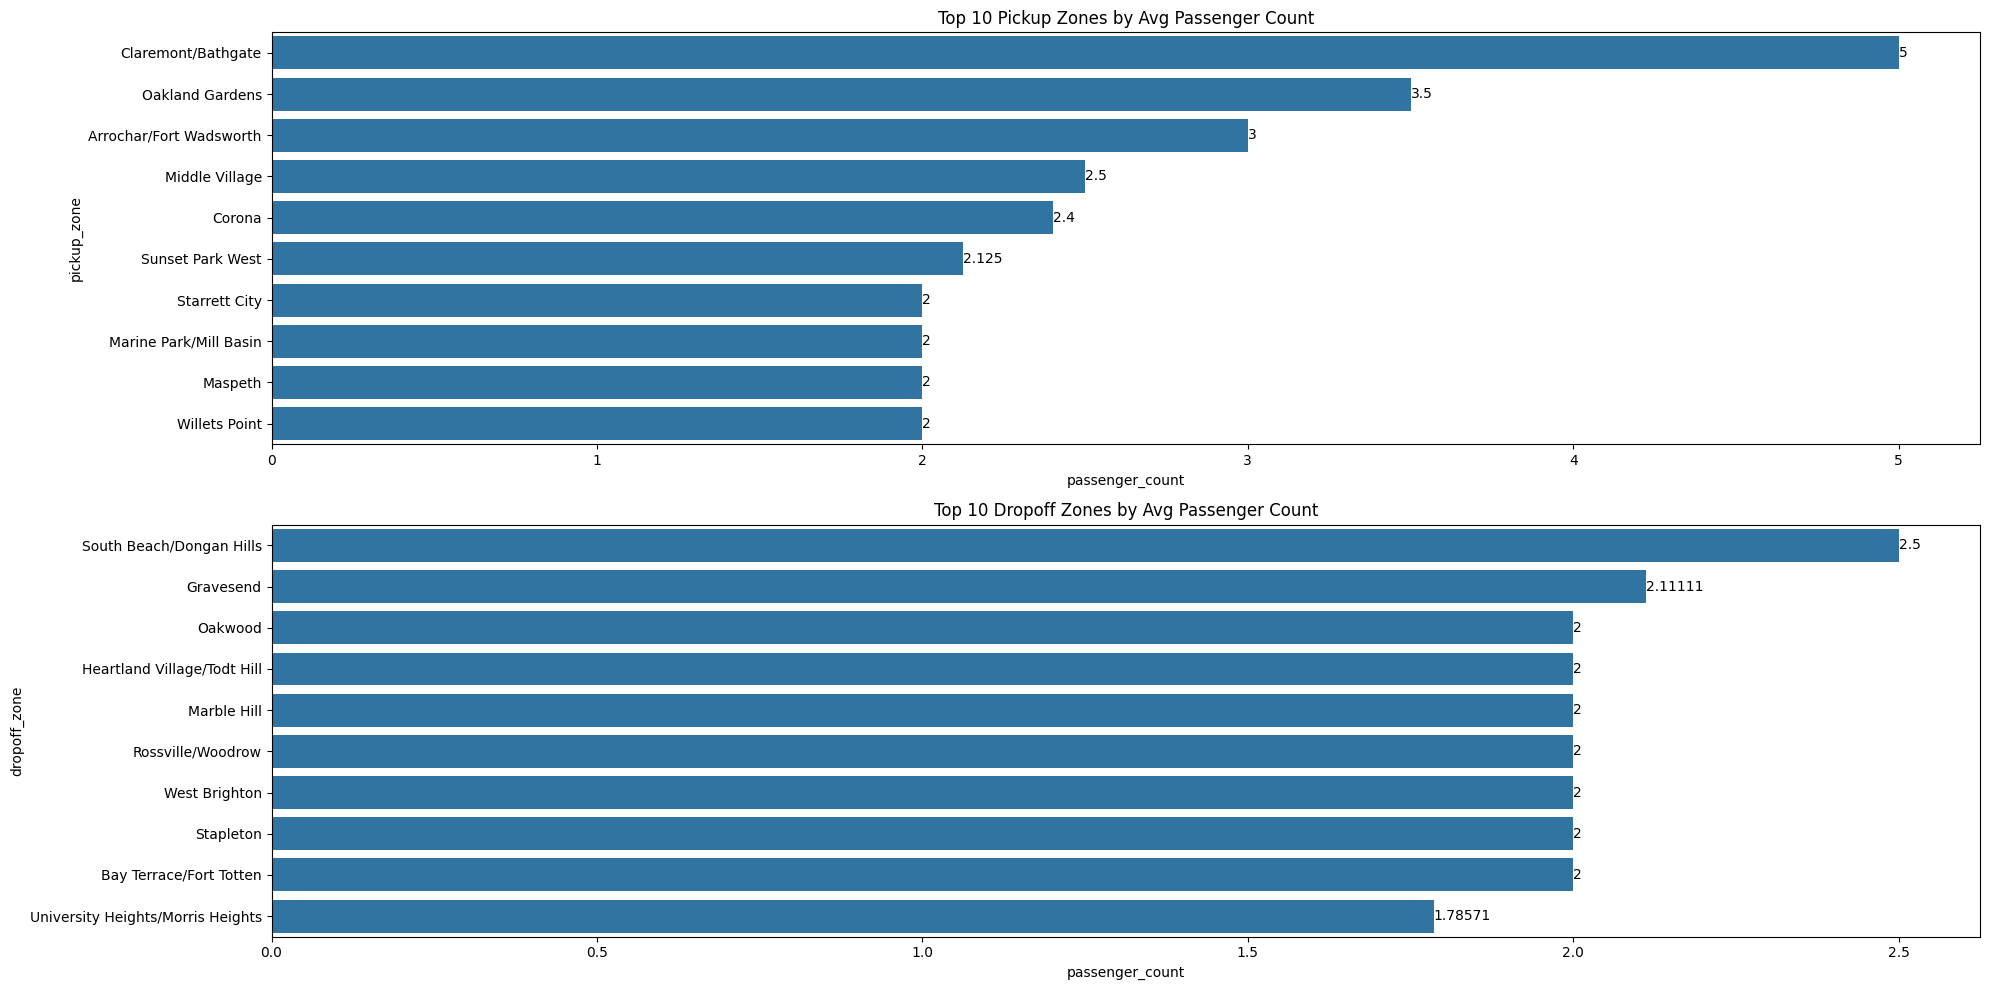

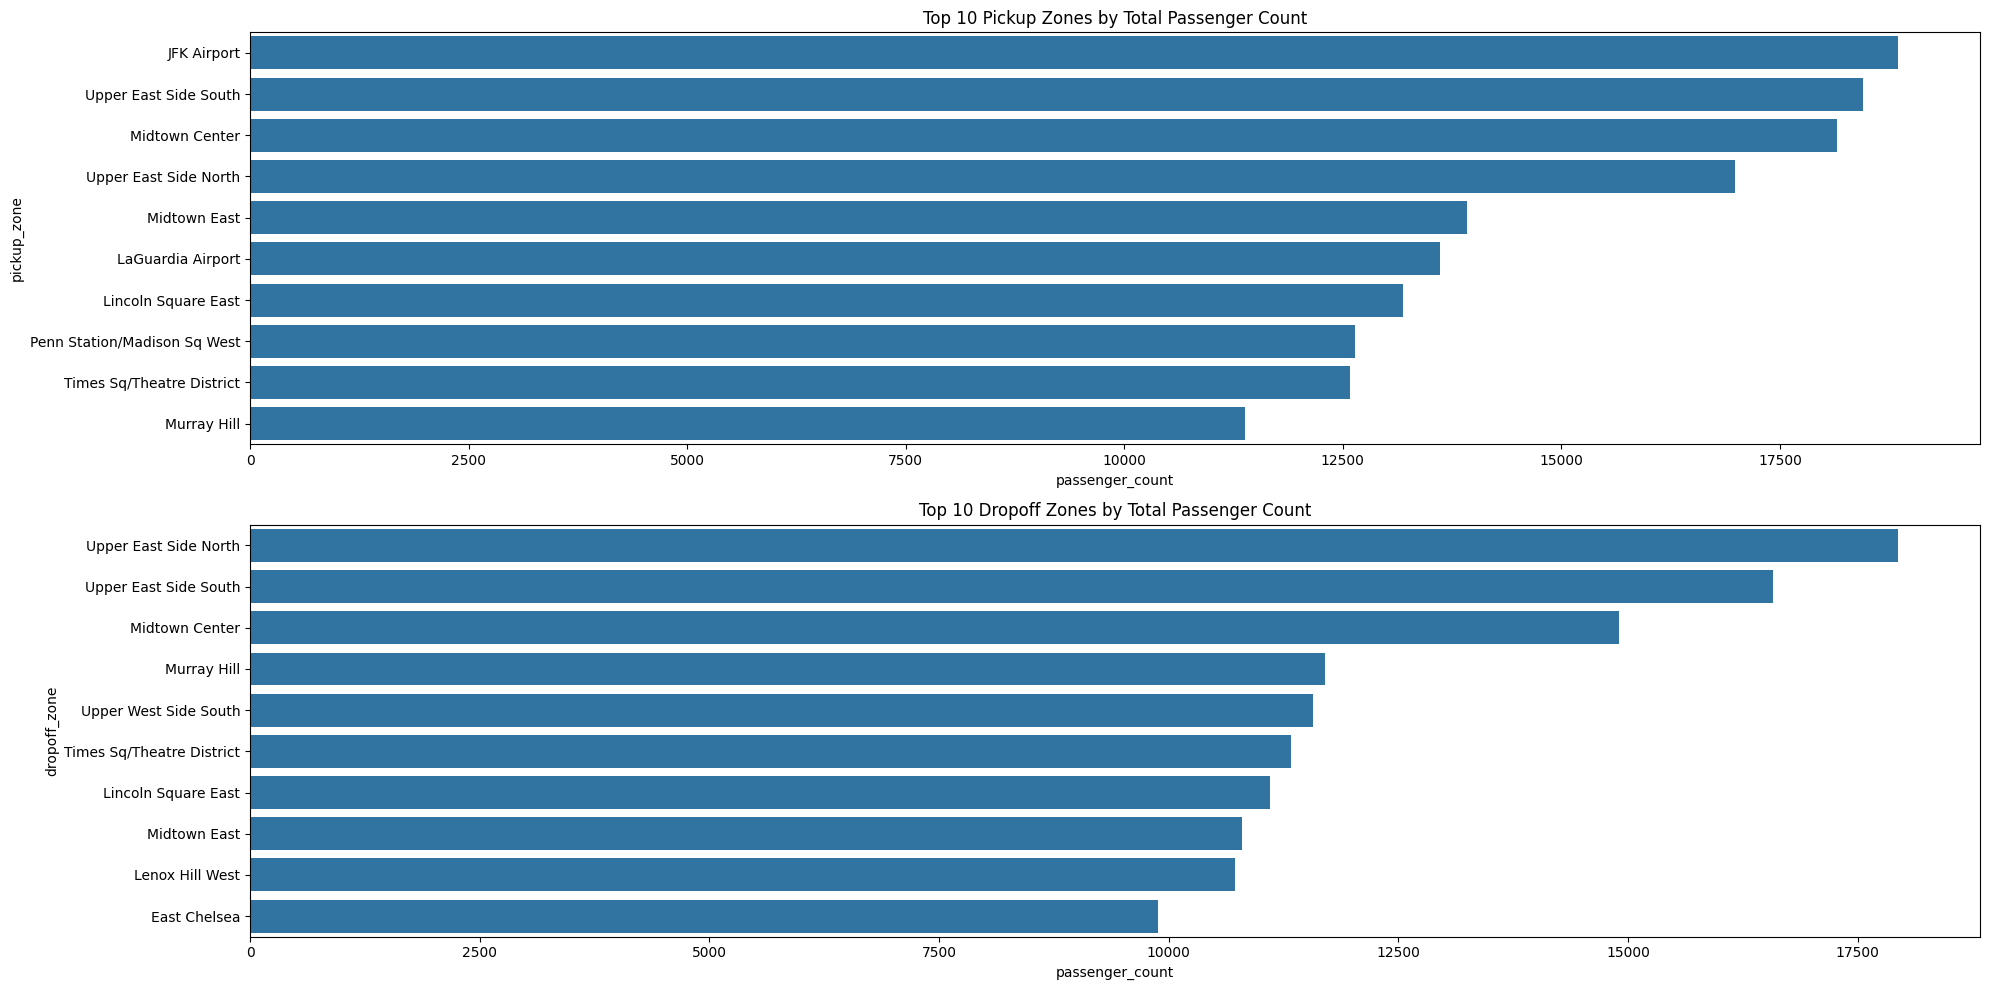

In [65]:
# How does passenger count vary across zones
pickup_zone_avg_passenger_counts = new_combined_df.groupby('pickup_zone')['passenger_count'].mean().reset_index()
dropoff_zone_avg_passenger_counts = new_combined_df.groupby('dropoff_zone')['passenger_count'].mean().reset_index()

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax = sns.barplot(x='passenger_count', y='pickup_zone', data=pickup_zone_avg_passenger_counts.sort_values(by='passenger_count', ascending=False).head(10))
ax.bar_label(ax.containers[0])
plt.title('Top 10 Pickup Zones by Avg Passenger Count')

plt.subplot(2, 1, 2)
ax = sns.barplot(x='passenger_count', y='dropoff_zone', data=dropoff_zone_avg_passenger_counts.sort_values(by='passenger_count', ascending=False).head(10))
ax.bar_label(ax.containers[0])
plt.title('Top 10 Dropoff Zones by Avg Passenger Count')

plt.tight_layout()
plt.show()

pickup_zone_avg_passenger_counts = new_combined_df.groupby('pickup_zone')['passenger_count'].sum().reset_index()
dropoff_zone_avg_passenger_counts = new_combined_df.groupby('dropoff_zone')['passenger_count'].sum().reset_index()

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='passenger_count', y='pickup_zone', data=pickup_zone_avg_passenger_counts.sort_values(by='passenger_count', ascending=False).head(10))
plt.title('Top 10 Pickup Zones by Total Passenger Count')

plt.subplot(2, 1, 2)
sns.barplot(x='passenger_count', y='dropoff_zone', data=dropoff_zone_avg_passenger_counts.sort_values(by='passenger_count', ascending=False).head(10))
plt.title('Top 10 Dropoff Zones by Total Passenger Count')

plt.tight_layout()
plt.show()

In [66]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
print(df.columns)




Index(['VendorID', 'pickup_hour', 'fare_per_mile'], dtype='object')


Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [67]:
# How often is each surcharge applied?
surcharge_columns = ['extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee']
surcharge_frequencies = new_combined_df[surcharge_columns].astype(bool).sum(axis=0).reset_index()
surcharge_frequencies.columns = ['Surcharge_Type', 'Frequency']

display(surcharge_frequencies.sort_values(by='Frequency',ascending=False))


,Surcharge_Type,Frequency
2,tip_amount,282922
4,improvement_surcharge,282919
1,mta_tax,281393
5,congestion_surcharge,268650
0,extra,179521
6,airport_fee,23192
3,tolls_amount,22645


## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

Routing and Dispatch Optimization Recommendations
1. Peak Hour Management
Weekday peaks: 5–7 PM; Weekend peaks: 11 PM–5 AM.

Deploy more taxis during these times to match demand.

2. Route Optimization
Use average speed and traffic data to reroute taxis around slow routes.

Prioritize dispatch to high-demand zones like Midtown Center, Upper East Side South, and JFK.

Scale back in low-demand zones during off-peak hours for better efficiency.

3. Customer Experience
Ensure quick pickups by positioning taxis in busy areas during peak times.

Offer discounts in low-demand zones and off-peak hours to increase rides and utilization.

**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

Focus on high-demand zones like Upper East Side South, Midtown Center, Upper East Side North, JFK Airport, and Midtown East—especially during peak hours—to reduce wait times.

On weekdays, deploy more cabs in business and residential areas during evening rush hours.

On weekends, target evening and late-night shifts in shopping, entertainment, and tourist zones.

Increase fleet during peak seasons (May–June, Oct–Dec) with seasonal cabs to meet higher demand.

Partner with hotels, businesses, and event venues to offer dedicated services during busy periods.

Use real-time and historical data to monitor trends and adjust cab positioning proactively.

**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

Implement dynamic pricing based on demand patterns—raise fares during peak hours (5–7 PM) and late nights (11 PM–5 AM).

Offer discounts during off-peak hours to boost ridership and utilization.

Use tiered pricing: keep short-trip fares competitive; slightly increase rates for medium and long trips.

Monitor competitor pricing to stay competitive and profitable.

Leverage real-time data to adjust pricing based on supply and demand.

Apply surge pricing in high-demand zones and times.

Introduce loyalty programs to encourage repeat rides and customer retention.